In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import sys
from tqdm import tqdm
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/psix_project/psix/psix/')
import psix

# Alternative splicing in mouse brain development

Here we analyse a smart-seq2 dataset from [Tiklova et al (2019)](https://www.nature.com/articles/s41467-019-08453-1) that follows the development of brain neurons at different stages of development: E13.5, E15.5, E18.5, P0, P7, P15 and P90.

This dataset originally consists of 1699 cells. However, after quality control and normalization, we removed many cells that either had poor coverage, or that were found to be non-neural cells (mostly oligodendrocytes). This left a total of 1067 single neurons. After preprocessing, we observe a clear trajectory of neuron development in this dataset:

<img src="plots/PCA_neurogenesis.png">

## Identifying informative exons with Psix

[Psix](https://github.com/cfbuenabadn/psix) is an autocorrelation-inspired computational tool that identifies informative exons in single cells. In order to run, Psix requires three inputs:

* Alternative splicing rates, or $\Psi$, per exon per cell.
* mRNA counts per exon. The mRNAs that are *informative* about the splicing of the exon. 
* An **interpretable** cell-cell similarity metric to infer what cells are close or similar to each other. This can be a latent space from a dimensionality reduction process.

It is important that the dimensionality reduction map is interpretable, such as the result of PCA, ZINBWave or scVI. It is **not** recommended to run Psix on non-interpretable visualization manifolds such as tSNE or UMAP.

### Step 1: create Psix object and pre-process smart-seq data.

There are many approaches to estimating the exon $\Psi$ and mRNA counts matrices. Psix has a built-in functionality that can produce these two matrices from:
* A matrix of exon splice junctions
* Amatrix of constitutive splice junctions
* A matrix of TPM counts. 

You can get the matrices of exon and constitutive splice juntions directly from the output of STAR alignment using out pre-processing package [sc-splicing-tools](https://github.com/cfbuenabadn/sc_splicing_tools). Future versions of Psix and of sc-splicing-tools will handle a single splice junction counts file for both alternative exons and constitutive junctions.

This step will create a $\Psi$ per cell table, estimate the mRNAs per genes using the Census normalization, and estimate the mRNAs per exon by adjusting the reads by junction coverage.

In [3]:
psix_object = psix.Psix()
psix_object.process_rnaseq(
        'data/preprocess/tables/SE_counts_filtered.tab.gz',
        'data/preprocess/tables/constitutive_introns_filtered.tab.gz',
        'data/preprocess/tables/rsem_gene_tpm_filtered.tab.gz',
        minJR = 1,
        minCell=1,
        min_observed = 0.25)

Obtaining psi tables...
Reading TPM and transforming to mRNA counts...


100%|██████████| 1067/1067 [00:43<00:00, 24.56it/s]


Successfully processed RNA-seq data


In [4]:
psix_object.adata.uns['psi'].T.to_csv('data/preprocess/tables/psi.tab.gz', sep='\t', index=True, header=True)
psix_object.adata.uns['mrna_per_event'].T.to_csv('data/preprocess/tables/mrna_per_event.tab.gz', 
                                                 sep='\t', index=True, header=True)

### Step 2: Computing exon scores with Psix

Psix can be called to compute the scores for each exon. In order to do that, a cell metric has to be provided. Here we provide the PCA dimensionality reduction of the normalized data obtained in `data/preprocess/preprocess.ipynb`. For each cell, Psix will identify its closest k nearest neighbors and estimate its mean $\hat{\Psi}$. By default Psix works with 100 neighbors - since drop-outs are not informative for splicing, we use a larger number of neighbors than it is usually used for gene expression analysis.

Psix then estimates the probability of observing the $\hat{\Psi}$ of each cell, given the weighted mean $\hat{\Psi}$ of it's k-nearest neighbors, and compare it to the probability of the same observation given the mean $\hat{\Psi}$ of the entire cell population. This is based on the idea that informative exons are autocorrelated to cell identity in the cell-cell metric.

P-values are estimated with random permutations of the data. This is the most time consuming step, thus parallelizing is recommended.

In [5]:
psix_object.compute_psix_scores(latent='data/preprocess/tables/pc2_rd.tab.gz', n_jobs=25, n_random_exons=2000)

  0%|          | 0/1067 [00:00<?, ?it/s]

cell-cell metric not found. Computing metric...


100%|██████████| 1067/1067 [00:00<00:00, 2085.16it/s]

Successfully computed cell-cell metric
Computing Psix score in 2087 exons



100%|██████████| 2087/2087 [00:18<00:00, 113.41it/s]


Successfully computed Psix score of exons.
...

Estimating p-values. This might take a while...


100%|██████████| 25/25 [08:12<00:00, 19.69s/it]  


Successfully estimated p-values


We can see the results from Psix:

In [6]:
psix_results = psix_object.psix_results
psix_results.head()

psix_score   pvals    qvals
Mapt_1      2.548385  0.0005  0.00178
Dbn1_1      2.267717  0.0005  0.00178
Ndrg4_1     2.214822  0.0005  0.00178
Mapt_3      1.887938  0.0005  0.00178
Gabrg2_1    1.835597  0.0005  0.00178

### Saving Psix results

Finally, we save our Psix object for later use. This way we can load the results without having to go through the calculations again.

In [8]:
psix_object.save_psix_object(overwrite=True)

### Informative exons found by Psix

Here we visualize the exon scores obtained by Psix, vs the scores of the randomized exons that Psix used for significance estimation. We highlight the score of some exons associated to neurogenesis.

100%|██████████| 2087/2087 [00:13<00:00, 152.29it/s]


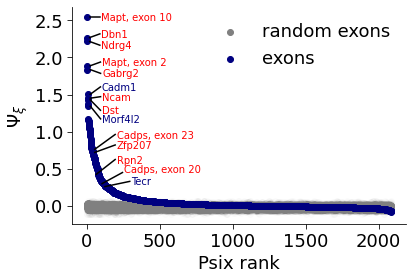

In [11]:
psix_results = psix_object.psix_results.copy()
psix_results['bins'] = ['']*2087

for mean in psix_object.bins.keys():
    for var in psix_object.bins[mean].keys():
        for exon in psix_object.bins[mean][var]:
            psix_results.loc[exon, 'bins'] = mean +'_' + var
            
fig = plt.figure()
ax  = plt.subplot(1,1,1)
i = 1

ax.scatter([100], [-0.05], c='gray', label='random exons')

for mean_var in tqdm(psix_results.sort_values('psix_score')[::-1].bins):
    mean = mean_var[:6]
    var = mean_var[7:]
    subset = np.random.choice(psix_object.random_scores[mean][var], 50, replace=False)
    ax.scatter([i]*50, subset, c='gray', alpha=0.02)
    i += 1


plt.text(100, psix_results.loc['Mapt_1'].psix_score-0.05, 'Mapt, exon 10', c='red')   
plt.plot([20, 90], [psix_results.loc['Mapt_1'].psix_score, psix_results.loc['Mapt_1'].psix_score],c='black')

plt.text(100, psix_results.loc['Ndrg4_1'].psix_score-0.1, 'Ndrg4', c='red')   
plt.plot([20, 90], [psix_results.loc['Ndrg4_1'].psix_score, psix_results.loc['Ndrg4_1'].psix_score-0.05],c='black')

plt.text(100, psix_results.loc['Dbn1_1'].psix_score, 'Dbn1', c='red')   
plt.plot([20, 90], [psix_results.loc['Dbn1_1'].psix_score, psix_results.loc['Dbn1_1'].psix_score+0.05],c='black')

plt.text(104, psix_results.loc['Mapt_3'].psix_score, 'Mapt, exon 2', c='red')    
plt.plot([24, 94], [psix_results.loc['Mapt_3'].psix_score, psix_results.loc['Mapt_3'].psix_score+0.05],c='black')

plt.text(105, psix_results.loc['Gabrg2_1'].psix_score-0.1, 'Gabrg2', c='red')   
plt.plot([25, 95], [psix_results.loc['Gabrg2_1'].psix_score, psix_results.loc['Gabrg2_1'].psix_score-0.05],c='black')

plt.text(104, psix_results.loc['Cadm1_10'].psix_score+0.05, 'Cadm1', c='navy')    
plt.plot([24, 94], [psix_results.loc['Cadm1_10'].psix_score, psix_results.loc['Cadm1_10'].psix_score+0.1],c='black')

plt.text(105, psix_results.loc['Ncam1_6'].psix_score-0.03, 'Ncam', c='red')   
plt.plot([25, 95], [psix_results.loc['Ncam1_6'].psix_score, psix_results.loc['Ncam1_6'].psix_score+0.02],c='black')

plt.text(104, psix_results.loc['Dst_5'].psix_score-0.19, 'Dst', c='red')    
plt.plot([24, 94], [psix_results.loc['Dst_5'].psix_score, psix_results.loc['Dst_5'].psix_score-0.14],c='black')

plt.text(105, psix_results.loc['Morf4l2_7'].psix_score-0.22, 'Morf4l2', c='navy')   
plt.plot([25, 95], [psix_results.loc['Morf4l2_7'].psix_score, psix_results.loc['Morf4l2_7'].psix_score-0.17],c='black')

plt.text(305, psix_results.loc['Tecr_6'].psix_score+0.02, 'Tecr', c='navy')   
plt.plot([125, 295], [psix_results.loc['Tecr_6'].psix_score, psix_results.loc['Tecr_6'].psix_score+0.07],c='black')

plt.text(205, psix_results.loc['Rpn2_3'].psix_score+0.15, 'Rpn2', c='red')   
plt.plot([65, 195], [psix_results.loc['Rpn2_3'].psix_score, psix_results.loc['Rpn2_3'].psix_score+0.2],c='black')

plt.text(255, psix_results.loc['Cadps_2'].psix_score+0.15, 'Cadps, exon 20', c='red')   
plt.plot([105, 245], [psix_results.loc['Cadps_2'].psix_score, psix_results.loc['Cadps_2'].psix_score+0.15],c='black')

plt.text(205, psix_results.loc['Cadps_7'].psix_score+0.15, 'Cadps, exon 23', c='red')   
plt.plot([55, 195], [psix_results.loc['Cadps_7'].psix_score, psix_results.loc['Cadps_7'].psix_score+0.2],c='black')

plt.text(205, psix_results.loc['Zfp207_1'].psix_score+0.05, 'Zfp207', c='red')   
plt.plot([55, 195], [psix_results.loc['Zfp207_1'].psix_score, psix_results.loc['Zfp207_1'].psix_score+0.1],c='black')

ax.scatter(np.arange(1, len(psix_results.index)+1), psix_results.sort_values('psix_score')[::-1].psix_score, c = 'navy',
          label='exons')
    
plt.xlabel('Psix rank', fontsize=18)
plt.ylabel(r'$\Psi_{\xi}$', fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=18, length=5)
plt.legend(frameon=False, fontsize=18)

# plt.savefig('plots/psix_scores.png', bbox_inches='tight', res=100)
# plt.savefig('plots/psix_scores.svg', bbox_inches='tight')
# plt.savefig('plots/psix_scores.pdf', bbox_inches='tight')

## Modules of splicing co-regulation

The noisiness of scRNA-seq data makes the analysis of splicing co-regulation very difficult. Spatial autocorrelation methods like [Hotspot](https://www.biorxiv.org/content/10.1101/2020.02.06.937805v1) use the information from neighborhoods of cells to find modules of co-expression. Here we take advantage of Psix's calculation of the weighted mean of each cell's k-nearest neighbors to obtain a matrix of correlation between significant exons.

In [9]:
psix_object.compute_neighbors_psi(latent='data/preprocess/tables/pc2_rd.tab.gz')

Successfully computed neighbors


In [14]:
psix_object.adata.uns['neighbors_psi'].T.to_csv('data/preprocess/tables/neighbors_psi.tab.gz', sep='\t', 
                                                index=True, header=True)

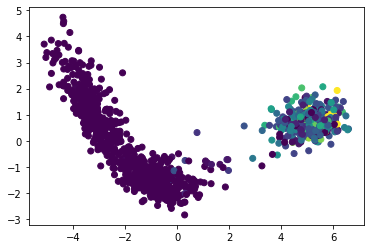

In [81]:
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
psix_results = pd.read_csv('psix_object/psix_results.tab.gz', sep='\t', index_col=0)
psi = psix_object.adata.uns['psi']

pc = PCA(5)
pca = pc.fit_transform(KNNImputer().fit_transform(psi[psix_results.loc[psix_results.qvals <= 0.05].index].T).T)
plt.scatter(pca.T[0], pca.T[1], c=psi['Mapt_1'])

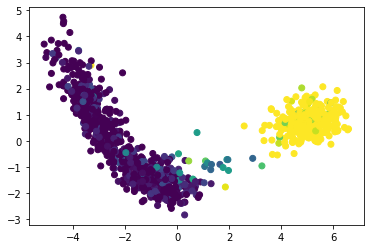

In [83]:
plt.scatter(pca.T[0], pca.T[1], c=psi['Mapt_1'])

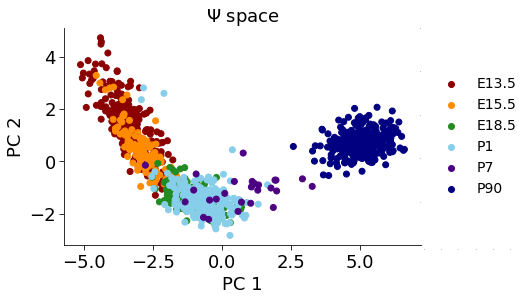

In [85]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8, 4))
gs = GridSpec(1,5)
gs.update(wspace=0.05, hspace=0.10)
ax = fig.add_subplot(gs[0,0:4])
ax_2 = fig.add_subplot(gs[0,4])
ax.scatter(pca.T[0], pca.T[1], c=colores)
ax.tick_params(labelsize=18, length=5)
ax.set_title('$\Psi$ space', fontsize=18)
ax.set_xlabel('PC 1', fontsize=18)
ax.set_ylabel('PC 2', fontsize=18)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax_2.scatter([-1], [0], c='darkred', label='E13.5')
ax_2.scatter([0], [0], c='darkorange', label='E15.5')
ax_2.scatter([0], [0], c='forestgreen', label='E18.5')
ax_2.scatter([0], [0], c='skyblue', label='P1')
ax_2.scatter([0], [0], c='indigo', label='P7')
ax_2.scatter([0], [0], c='navy', label='P90')
ax_2.spines["right"].set_visible(False)
ax_2.spines["top"].set_visible(False)
ax_2.spines["bottom"].set_visible(False)
ax_2.spines["left"].set_visible(False)
ax_2.tick_params(labelsize=0, length=0, which='both')
ax_2.set_xlim([2, 3])
ax_2.set_ylim([2, 3])
ax_2.legend(frameon=False, fontsize=14, loc='center left')

(array([623.,  96.,  25.,  12.,   5.,   9.,   4.,   4.,  11., 273.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

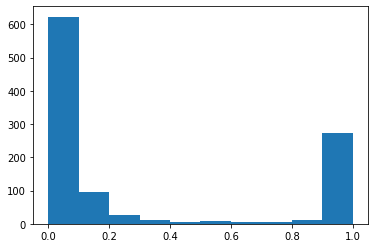

In [57]:
plt.hist(psi[psix_results.loc[psix_results.qvals <= 0.05].index]['Mapt_1'])

(array([819.,  50.,  69.,  38.,  26.,  22.,  15.,   7.,   7.,   9.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

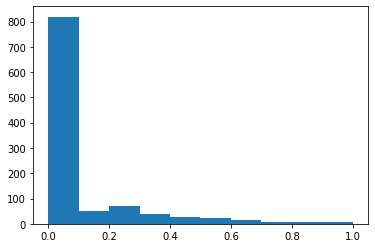

In [62]:
plt.hist(psi[psix_results.loc[psix_results.qvals <= 0.05].index][psix_results.loc[psix_results.qvals <= 0.05].index[3]])

(array([823.,  50.,  69.,  38.,  27.,  22.,  15.,   7.,   7.,   9.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

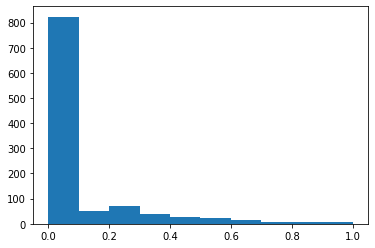

In [64]:
plt.hist(KNNImputer().fit_transform(psi[psix_results.loc[psix_results.qvals <= 0.05].index].T)[3])

In [117]:
plt.scatter(psix_object.adata.uns['latent'].PC_1, psix_object.adata.uns['latent'].PC_2, 
                    c=psix_object.adata.uns['psi']['Clta_1'])

KeyError: 'latent'

In [ ]:
plt.scatter(psix_object.adata.uns['latent'].PC_1, psix_object.adata.uns['latent'].PC_2, 
                    c=KNNImputer().fit_transform(psi[psix_results.loc[psix_results.qvals <= 0.05].index]['Clta_1'])

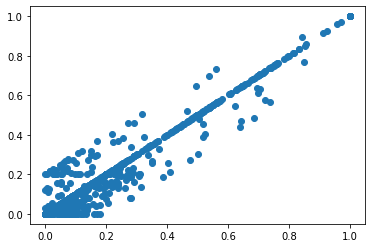

In [79]:
plt.scatter(KNNImputer().fit_transform(psi[psix_results.loc[psix_results.qvals <= 0.05].index].T)[200], 
           KNNImputer().fit_transform(psi[psix_results.index].T)[200])

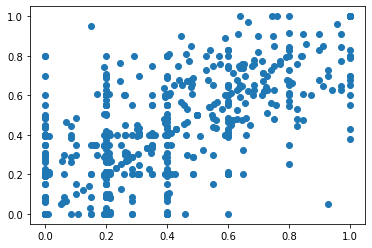

In [78]:
plt.scatter(KNNImputer().fit_transform(psi[psix_results.loc[psix_results.qvals <= 0.05].index]).T[200], 
           KNNImputer().fit_transform(psi[psix_results.index]).T[200])

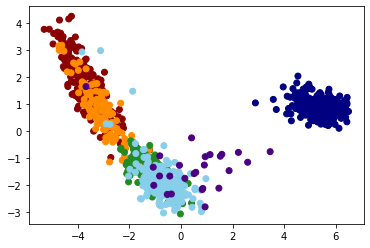

In [50]:
meta = pd.read_csv('data/SraRunTable.txt.gz', index_col=0)

from matplotlib import pyplot as plt
colores = []
for cell in meta.loc[psi.index].Age:
    if cell == 'embryonic day 13.5':
        colores.append('darkred')
    if cell == 'embryonic day 15.5':
        colores.append('darkorange')
    if cell == 'embryonic day 18.5':
        colores.append('forestgreen')
    if cell == 'postnatal day 1':
        colores.append('skyblue')
    if cell == 'postnatal day 7':
        colores.append('indigo')
    if cell == 'postnatal day 90':
        colores.append('navy')
        
plt.scatter(pca.T[0], pca.T[1], c=colores)

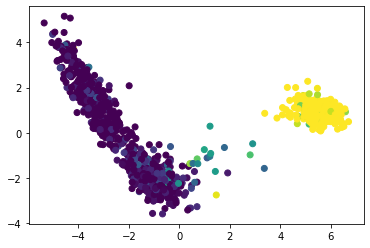

In [51]:
pc = PCA(5)
pca = pc.fit_transform(KNNImputer().fit_transform(psi))
plt.scatter(pca.T[0], pca.T[1], c=psi['Mapt_1'])

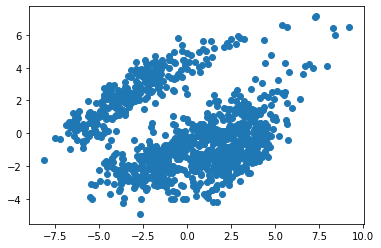

In [42]:
pc = PCA(5)
pca = pc.fit_transform((~psi[psix_results.loc[psix_results.qvals <= 0.05].index].isna()).astype(int))
plt.scatter(pca.T[0], pca.T[1])

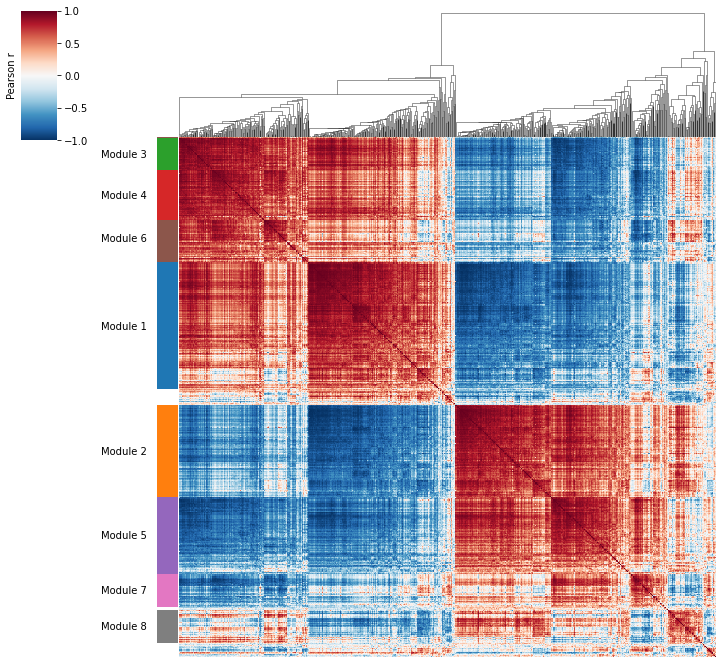

In [10]:
import sys
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/psix_project/analysis_psix/utils/')
from misc_utils import *

background_psi = psix_object.adata.uns['neighbors_psi'].mask(psix_object.adata.uns['psi'].isna()).T
exon_list = psix_results.loc[(psix_results.psix_score > 0) & (psix_results.qvals <= 0.05)].index

bwow = compute_modules(background_psi.loc[exon_list].T.corr().fillna(0), 
                min_gene_threshold=30, fdr_threshold=None, z_threshold=0.3, core_only=False)

aver = local_correlation_plot(
            background_psi.loc[exon_list].T.corr().fillna(0), bwow[0], bwow[1],
            mod_cmap='tab10', vmin=-1, vmax=1,
            z_cmap='RdBu_r', yticklabels=False
)

We then use a modification of the UPGMA alogithm as implemented in Hotspot to estimate modules of co-spliced exons.

We find that these modules are associated to temporal changes in splicing.

(2.0, 4.0)

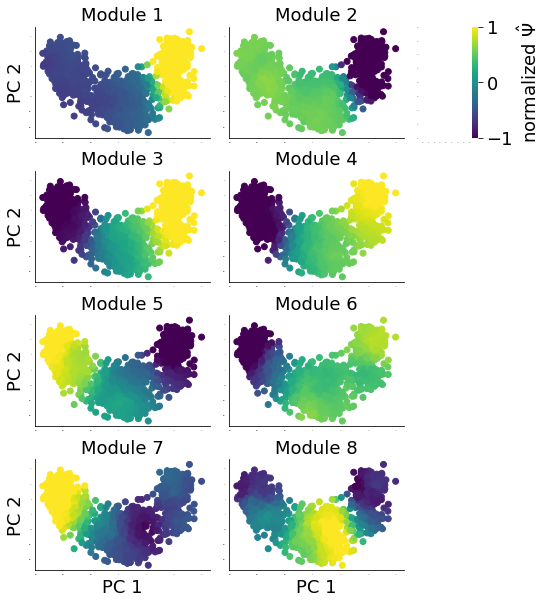

In [11]:
from scipy.stats import zscore
from itertools import product
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8, 10))
gs = GridSpec(4,12)
gs.update(wspace=1, hspace=0.3)

ax_positions = list(product(range(4), range(2)))

background_psi = psix_object.adata.uns['neighbors_psi'].T

for mod in range(1, 9):
    
    mad_df = pd.DataFrame()
    for exon in bwow[0].index[bwow[0]==mod]:
        mad_df[exon] = zscore(background_psi.loc[exon])
    mad_df.index= psix_object.adata.uns['psi'].index
    
    x, y = ax_positions[mod-1]
    
    ax = fig.add_subplot(gs[x,(5*y):(5*y)+5])

    sc = ax.scatter(psix_object.latent.PC_1, 
                    psix_object.latent.PC_2, 
                    c=mad_df.mean(axis=1), vmin=-1, vmax=1, cmap='viridis')
    
    
    plt.title('Module '+str(mod), fontsize=18)
    if x == 3:
        plt.xlabel('PC 1', fontsize=18)
    if y == 0:
        plt.ylabel('PC 2', fontsize=18)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.tick_params(labelsize=0, length=0)
    ax.grid(False)
#     plt.show()
ax = fig.add_subplot(gs[0,10:12])
ax.grid(False)
sc = ax.scatter([0, 0], [0, 0], c=[-1, 1])
cb = plt.colorbar(sc, shrink = 1, aspect=20)
cb.set_label(label='normalized $\hat{\Psi}$',size=18)
cb.ax.tick_params(labelsize=18, length=5)
cb.outline.set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax.tick_params(labelsize=0, length=0)
ax.set_xlim((2, 4))
ax.set_ylim((2, 4))

In [12]:
pd.DataFrame(bwow[0]).to_csv('psix_object/modules.tab.gz', sep='\t', index=True, header=True)

## Regulation of alternative splicing in exon modules

In [13]:
motif_dir = '~/Network/Mouse/SplicingNetwork/L_score_events/meme_motifs/'
mouse_motifs_exons = pd.read_csv(motif_dir + 'mouse_rbp.exons.tab', sep='\t', index_col=0)
mouse_motifs_ase = pd.read_csv(motif_dir + 'mouse_rbp.ase.tab', sep='\t', index_col=0)

human_motifs_exons = pd.read_csv(motif_dir + 'human_rbp.exons.tab', sep='\t', index_col=0)
human_motifs_ase = pd.read_csv(motif_dir + 'human_rbp.ase.tab', sep='\t', index_col=0)

clip_dir = '~/Network/Mouse/SplicingNetwork/L_score_events/tiklova/'
mouse_clip_predicted = pd.read_csv(clip_dir + 'peaks_predicted_mRBP.tab', sep='\t', index_col=0)
mouse_clip_peaks = pd.read_csv(clip_dir + 'peaks_clip_tags.tab', sep='\t', index_col=0)

mouse_clip_predicted = (mouse_clip_predicted.loc[[x for x in mouse_clip_predicted.index if x[-3:]=='_se']] > 0).astype(int)
mouse_clip_peaks = (mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:]=='_se']] > 0).astype(int)

mouse_clip_predicted.index= [x[:-3] for x in mouse_clip_predicted.index if x[-3:]=='_se']
mouse_clip_peaks.index= [x[:-3] for x in mouse_clip_peaks.index if x[-3:]=='_se']

clip_dir = '~/Network/Mouse/SplicingNetwork/L_score_events/tiklova_hRBP/'
human_clip_predicted = pd.read_csv(clip_dir + 'peaks_predicted_hRBP.tab', sep='\t', index_col=0)

human_clip_predicted = (human_clip_predicted.loc[[x for x in human_clip_predicted.index if x[-3:]=='_se']] > 0).astype(int)
human_clip_predicted.index= [x[:-3] for x in human_clip_predicted.index if x[-3:]=='_se']

clip_dir = '~/Network/Mouse/SplicingNetwork/L_score_events/tiklova/'

mouse_clip_peaks = pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0)

mouse_clip_predicted = (mouse_clip_predicted.loc[[x for x in mouse_clip_predicted.index if x[-3:]=='_se']] > 0).astype(int)
mouse_clip_peaks = (mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:]=='_se']] > 0).astype(int)

mouse_clip_predicted.index= [x[:-3] for x in mouse_clip_predicted.index if x[-3:]=='_se']
mouse_clip_peaks.index= [x[:-3] for x in mouse_clip_peaks.index if x[-3:]=='_se']


mouse_clip_peaks = pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0)
exon_lengths = pd.read_csv('~/Network/Mouse/SplicingNetwork/L_score_events/tiklova/exon_lengths.tab', sep='\t',
                           index_col=0, names=['exon', 'ase', 'length']).loc[mouse_clip_peaks.index]
exon_lengths.index == mouse_clip_peaks.index

mouse_clip_overlap = mouse_clip_peaks.divide(exon_lengths.length, axis=0)


mouse_clip_overlap = mouse_clip_overlap.loc[[x for x in mouse_clip_overlap.index if x[-3:]=='_se']]
mouse_clip_peaks = (mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:]=='_se']] > 0).astype(int)

mouse_clip_overlap.index= [x[:-3] for x in mouse_clip_overlap.index if x[-3:]=='_se']
mouse_clip_peaks.index= [x[:-3] for x in mouse_clip_peaks.index if x[-3:]=='_se']

exons_sorted = psix_results.loc[mouse_clip_overlap.index & psix_results.index].sort_values('psix_score').index[::-1]

list_modules = []

colores = ['forestgreen', 'indigo', 'brown', 'navy']

def enrichment_score(signal, exon_score=1):
    Nr = np.sum(signal)
    #exon_score = [1]*len(signal)
    denominator = len(signal) - np.sum(np.array(signal)>0)
    
    p_hit = []
    p_miss = []
    current_p_hit = 0
    current_p_miss = 0
    for i in range(len(signal)):
        if signal[i] > 0:
            current_p_hit += signal[i]/Nr
        else:
            current_p_miss += 1/denominator
        
        p_hit.append(current_p_hit)
        p_miss.append(current_p_miss)
        
    p_hit = np.array(p_hit)
    p_miss = np.array(p_miss)
    return p_hit-p_miss
    
def gsea(signal, permutations=2000):
    ES = np.max(enrichment_score(signal))
    ES_random = []
    for i in tqdm(range(permutations)):
        random_signal = np.random.choice(signal, len(signal), replace=False)
        ES_random.append(np.max(enrichment_score(random_signal)))
        
    ES_random = np.array(ES_random)
    p_val = (np.sum(ES_random >= ES)+1)/(permutations+1)
    return ES, p_val

# plt.plot(range(len(exons_sorted)),
#          enrichment_score(list(mouse_clip_overlap.loc[exons_sorted]['NOVA1'])))

In [14]:
import scipy.stats as ss
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests

def hyper_test(M, n, N, k):
    '''
    Calculates the hypergeometric test.
    
    Input:
      M: Population size (total exons tested)
      n: Successess in population (exons with p-value <= x)
      N: Sample size (exons selected)
      k: Successes in sample (selected exons with p-value <= x)
    Output:
      p_depleted: p-value of depletion from the hypergeometric test
      p_enriched: p-value of enrichment from the hypergeometric test
    '''
    hpd = hypergeom(M, n, N) # Hypergeometric distribution
    p_depleted = hpd.cdf(k)  # Get cummulative distribution up to k
    p_enriched = hpd.sf(k-1) # Survival function up to k-1 (1 - cdf(k-1))
    return p_depleted, p_enriched


def test_enrichment(binding, exon_cluster):
    M = len(binding)
    n = binding.sum()
    N = len(exon_cluster)
    k = binding.loc[exon_cluster].sum()
    p_depleted, p_enriched = hyper_test(M, n, N, k)
    
    enrichment = (k/N)/(n/M)
    
    if enrichment == 0:
        log_enrich = -3
    else:
        log_enrich = np.log2(enrichment)
        
    
    return p_enriched, p_depleted, log_enrich

In [15]:
clip_dir = '~/Network/Mouse/SplicingNetwork/L_score_events/tiklova/'

mouse_clip_peaks = (pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0) > 0).astype(int)
se_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_se']
e1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e1']
e2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e2']




mouse_clip_families = pd.DataFrame()
mouse_clip_families['NOVA_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_se'] = np.array(mouse_clip_peaks.loc[se_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['NOVA1', 'NOVA2']].max(axis=1))

mouse_clip_families['RBFOX_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_se'] = np.array(mouse_clip_peaks.loc[se_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))

# mouse_clip_families['MBNL_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
# mouse_clip_families['MBNL_se'] = np.array(mouse_clip_peaks.loc[se_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
# mouse_clip_families['MBNL_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))

mouse_clip_families['SRSF_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_se'] = np.array(mouse_clip_peaks.loc[se_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
# mouse_clip_families['CELF'] = mouse_clip_peaks['CELF4']#.max(axis=1)
# mouse_clip_families['TARDBP'] = mouse_clip_peaks['TARDBP']#.max(axis=1)
# mouse_clip_families['LIN28A'] = mouse_clip_peaks['LIN28A']#.max(axis=1)
mouse_clip_families.index = [x[:-3] for x in mouse_clip_peaks.index if (x[-3:]=='_se')]

modules = bwow[0]
modules = modules.loc[modules.index & mouse_clip_families.index]
mouse_clip_families = mouse_clip_families.loc[psix_results.index & mouse_clip_families.index]


# mouse_clip_predicted = (mouse_clip_predicted.loc[[x for x in mouse_clip_predicted.index if x[-3:]=='_se']] > 0).astype(int)
# mouse_clip_peaks = (mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:]=='_se']] > 0).astype(int)

# mouse_clip_predicted.index= [x[:-3] for x in mouse_clip_predicted.index if x[-3:]=='_se']
# mouse_clip_peaks.index= [x[:-3] for x in mouse_clip_peaks.index if x[-3:]=='_se']

hyper_enrichment = pd.DataFrame()
hyper_pval_enrich = pd.DataFrame()
hyper_pval_deplete = pd.DataFrame()
for rbp in mouse_clip_families.columns:
    p_enrich = []
    p_deplete = []
    log_enrich = []
    for module in range(1, 9):
        enrichment = test_enrichment(mouse_clip_families[rbp], modules.index[(modules==module)])
        p_enrich.append(enrichment[0])
        p_deplete.append(enrichment[1])
        log_enrich.append(enrichment[2])
        
    hyper_enrichment[rbp] = log_enrich
    hyper_pval_enrich[rbp] = p_enrich
    hyper_pval_deplete[rbp] = p_deplete
    
hyper_enrichment.index = ['M'+ str(x) for x in range(1, 9)]
hyper_pval_enrich.index = ['M'+ str(x) for x in range(1, 9)]
hyper_pval_deplete.index = ['M'+ str(x) for x in range(1, 9)]
    
        
hyper_enrich_significance = pd.DataFrame(multipletests(np.array(hyper_pval_enrich).reshape(1,-1)[0], 
                                                       method='fdr_bh')[1].reshape(8,-8)<=0.1)
hyper_enrich_significance.index = hyper_pval_enrich.index
hyper_enrich_significance.columns = hyper_pval_enrich.columns

labels = hyper_enrich_significance.copy()
for exon in hyper_enrich_significance.index:
    for rbp in hyper_enrich_significance.columns:
        if labels.loc[exon, rbp]:
            labels.loc[exon, rbp] = '*'
        else:
            labels.loc[exon, rbp] = ''
# from statsmodels.stats.multitest import multipletests

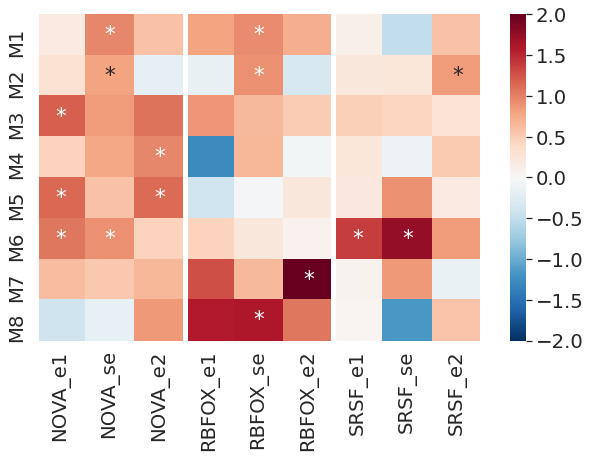

In [16]:
sns.set(font_scale=1.8)

fig = plt.figure(figsize=(10, 6))
ax = sns.heatmap(hyper_enrichment, cmap='RdBu_r', vmin=-2, vmax=2, annot=labels, fmt='')
for i in range(0, hyper_enrichment.shape[1] + 1, 3):
    ax.axvline(i, color='white', lw=5)
# for i in range(data.shape[1] + 1):
#     ax.axvline(i, color='white', lw=60)
plt.show()

In [17]:
modules.loc[[x for x in modules.index if 'Srsf' in x]]


Srsf9_nmdSE_1     1
Srsf9_nmdSE_2     1
Srsf9_2           1
Srsf6_nmdSE_1     6
Srsf6_1           6
Srsf7_nmdSE_1     6
Srsf2_1           6
Srsf11_nmdSE_2    1
Srsf10_nmdSE_1    6
Name: Module, dtype: int64

In [18]:
clip_dir = '~/Network/Mouse/SplicingNetwork/psix_events/'

mouse_clip_peaks = (pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0) > 0).astype(int)
s1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s1']
s2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s2']
e1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e1']
e2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e2']




mouse_clip_families = pd.DataFrame()
mouse_clip_families['NOVA_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['NOVA1', 'NOVA2']].max(axis=1))

mouse_clip_families['RBFOX_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))

# mouse_clip_families['MBNL_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
# mouse_clip_families['MBNL_se'] = np.array(mouse_clip_peaks.loc[se_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
# mouse_clip_families['MBNL_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))

mouse_clip_families['SRSF_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
# mouse_clip_families['CELF'] = mouse_clip_peaks['CELF4']#.max(axis=1)
# mouse_clip_families['TARDBP'] = mouse_clip_peaks['TARDBP']#.max(axis=1)
# mouse_clip_families['LIN28A'] = mouse_clip_peaks['LIN28A']#.max(axis=1)
mouse_clip_families.index = [x[:-3] for x in mouse_clip_peaks.index if (x[-3:]=='_s1')]

modules = bwow[0]
modules = modules.loc[modules.index & mouse_clip_families.index]
mouse_clip_families = mouse_clip_families.loc[psix_results.index & mouse_clip_families.index]

print(mouse_clip_families.shape)

# mouse_clip_predicted = (mouse_clip_predicted.loc[[x for x in mouse_clip_predicted.index if x[-3:]=='_se']] > 0).astype(int)
# mouse_clip_peaks = (mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:]=='_se']] > 0).astype(int)

# mouse_clip_predicted.index= [x[:-3] for x in mouse_clip_predicted.index if x[-3:]=='_se']
# mouse_clip_peaks.index= [x[:-3] for x in mouse_clip_peaks.index if x[-3:]=='_se']

hyper_enrichment = pd.DataFrame()
hyper_pval_enrich = pd.DataFrame()
hyper_pval_deplete = pd.DataFrame()
for rbp in mouse_clip_families.columns:
    p_enrich = []
    p_deplete = []
    log_enrich = []
    for module in range(1, 9):
        enrichment = test_enrichment(mouse_clip_families[rbp], modules.index[(modules==module)])
        p_enrich.append(enrichment[0])
        p_deplete.append(enrichment[1])
        log_enrich.append(enrichment[2])
        
    hyper_enrichment[rbp] = log_enrich
    hyper_pval_enrich[rbp] = p_enrich
    hyper_pval_deplete[rbp] = p_deplete
    
hyper_enrichment.index = ['M'+ str(x) for x in range(1, 9)]
hyper_pval_enrich.index = ['M'+ str(x) for x in range(1, 9)]
hyper_pval_deplete.index = ['M'+ str(x) for x in range(1, 9)]
    
        
hyper_enrich_significance = pd.DataFrame(multipletests(np.array(hyper_pval_enrich).reshape(1,-1)[0], 
                                                       method='fdr_bh')[1].reshape(8,-8)<=0.1)
hyper_enrich_significance.index = hyper_pval_enrich.index
hyper_enrich_significance.columns = hyper_pval_enrich.columns

labels = hyper_enrich_significance.copy()
for exon in hyper_enrich_significance.index:
    for rbp in hyper_enrich_significance.columns:
        if labels.loc[exon, rbp]:
            labels.loc[exon, rbp] = '*'
        else:
            labels.loc[exon, rbp] = ''
# from statsmodels.stats.multitest import multipletests

(2087, 12)


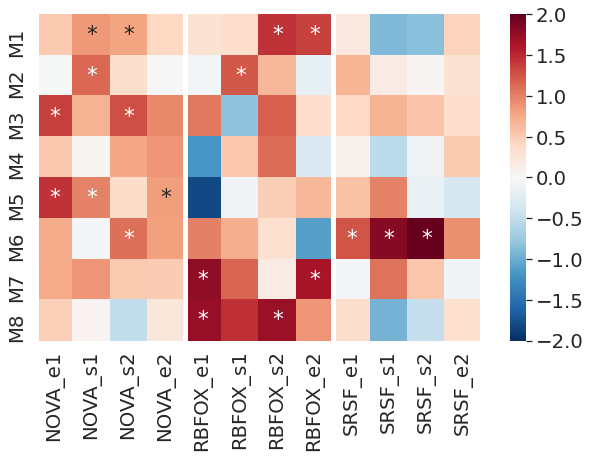

In [19]:
sns.set(font_scale=1.8)

fig = plt.figure(figsize=(10, 6))
ax = sns.heatmap(hyper_enrichment, cmap='RdBu_r', vmin=-2, vmax=2, annot=labels, fmt='')
for i in range(0, hyper_enrichment.shape[1] + 1, 4):
    ax.axvline(i, color='white', lw=5)
# for i in range(data.shape[1] + 1):
#     ax.axvline(i, color='white', lw=60)
plt.show()

In [20]:
modules.loc[[x for x in modules.index if 'Srsf' in x]]


Srsf9_nmdSE_1     1
Srsf9_nmdSE_2     1
Srsf9_2           1
Srsf6_nmdSE_1     6
Srsf6_1           6
Srsf7_nmdSE_1     6
Srsf2_1           6
Srsf11_nmdSE_2    1
Srsf10_nmdSE_1    6
Name: Module, dtype: int64

In [75]:
mouse_clip_peaks = pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0)

In [87]:
mouse_clip_peaks.loc[[x + '_s1' for x in modules.loc[modules == 6].index], 'SRSF6'].sort_values().tail(20)

Pxk_3_s1            0.000000
Tmem196_1_s1        0.000000
Agrn_10_s1          0.000000
Agrn_7_s1           0.000000
Chl1_2_s1           0.000000
Arhgef7_4_s1        0.000000
Tk2_2_s1            0.000000
Strada_5_s1         0.000000
Mcf2l_5_s1          0.000000
Mtdh_2_s1           0.000000
Mcf2l_2_s1          0.000000
Ptprf_7_s1          0.000000
Szrd1_1_s1          0.000000
Bclaf1_1_s1         0.114943
Clk4_5_s1           0.171233
Srsf2_1_s1          0.176471
Srsf7_nmdSE_1_s1    0.306878
Clk1_1_s1           0.753425
Srsf6_1_s1          0.836066
Srsf6_nmdSE_1_s1    0.850000
Name: SRSF6, dtype: float64

69

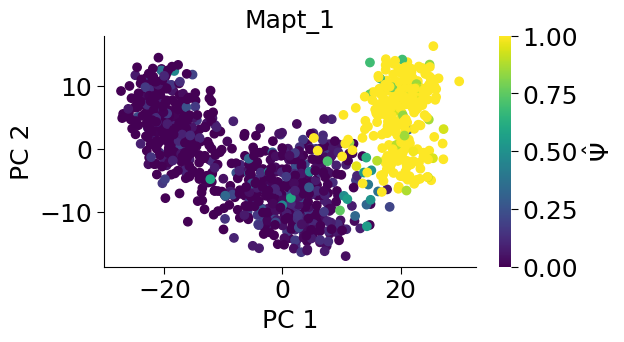

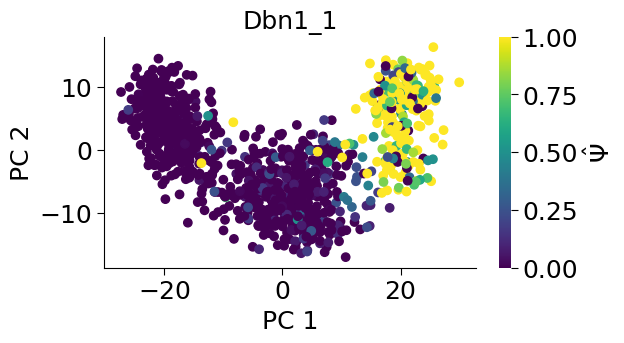

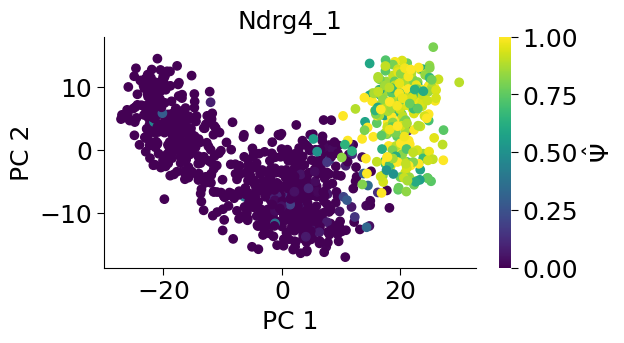

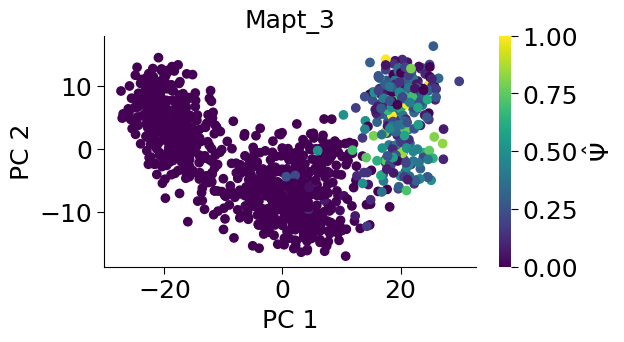

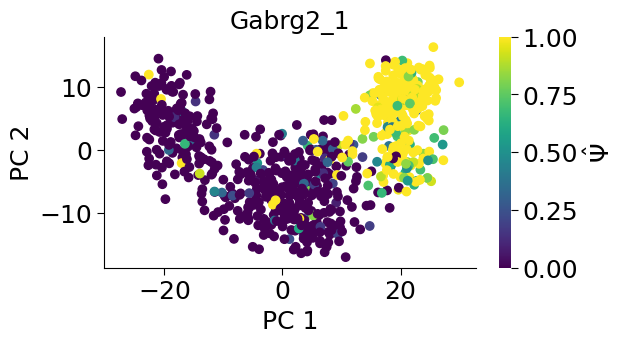

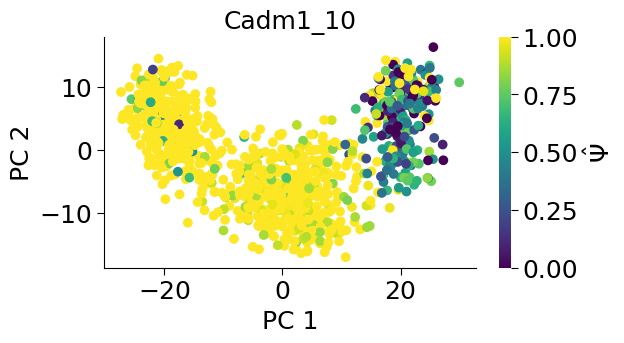

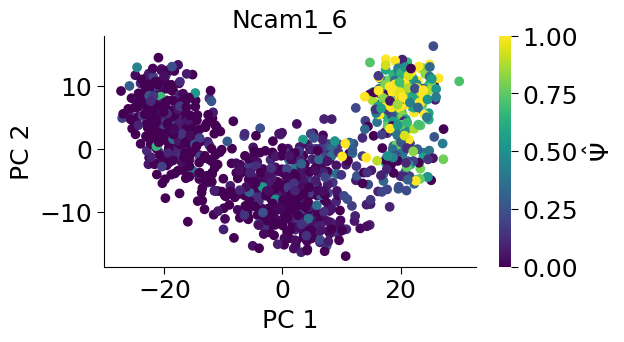

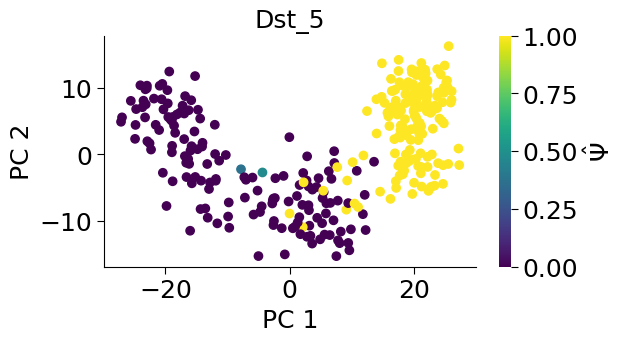

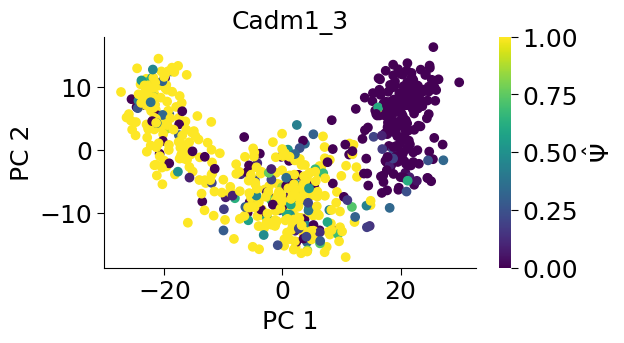

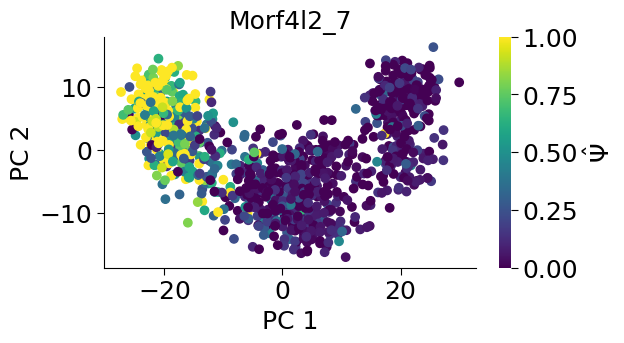

In [80]:
for exon in psix_results[:10].index:
    fig = plt.figure(figsize=(6, 3))
    ax  = plt.subplot(1,1,1)
    sc = ax.scatter(psix_object.adata.uns['latent'].PC_1, psix_object.adata.uns['latent'].PC_2, 
                    c=psix_object.adata.uns['psi'][exon])
    # cb = plt.colorbar(sc)
    ax.tick_params(labelsize=18, length=5)
    cb = plt.colorbar(sc, shrink = 1)
    cb.set_label(label='$\hat{\Psi}$',size=18)
    cb.ax.tick_params(labelsize=18, length=5)
    cb.outline.set_visible(False)
    plt.title(exon, fontsize=18)
    plt.xlabel('PC 1', fontsize=18)
    plt.ylabel('PC 2', fontsize=18)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
    
    plt.savefig('plots/' + exon +'.png', bbox_inches='tight', res=100)
    plt.savefig('plots/' + exon +'.svg', bbox_inches='tight')
    plt.savefig('plots/' + exon +'.pdf', bbox_inches='tight')



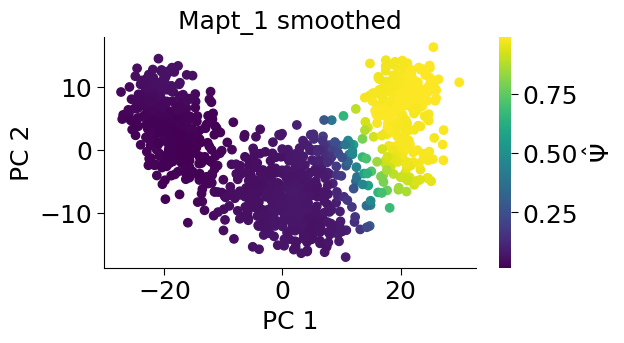

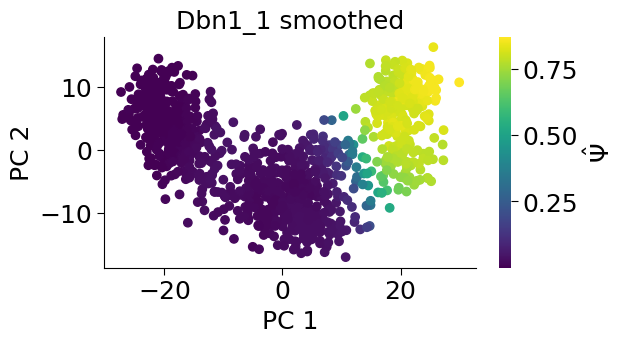

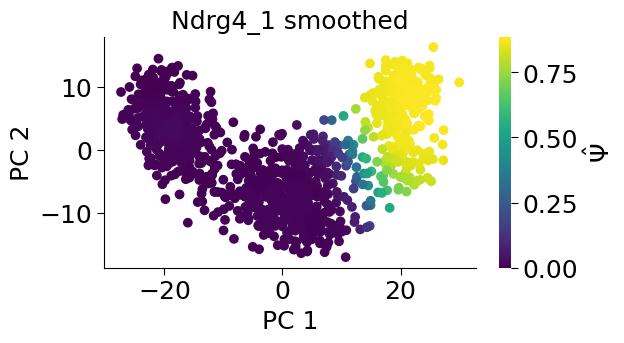

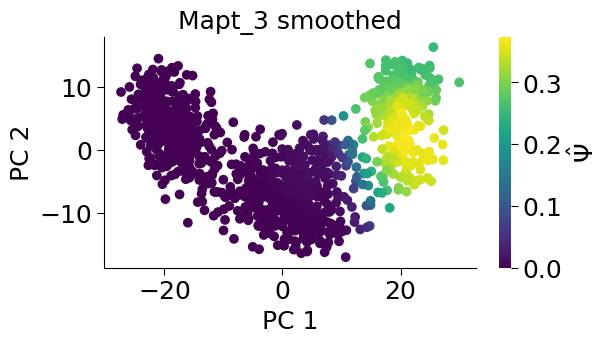

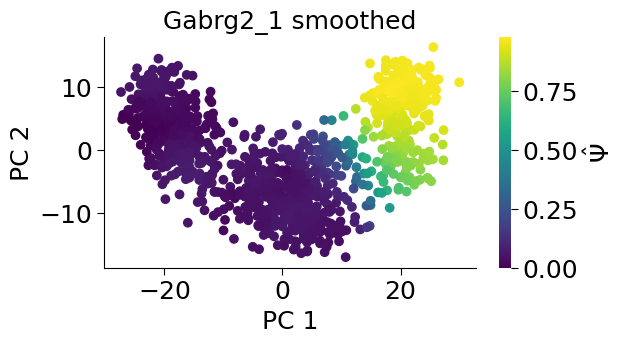

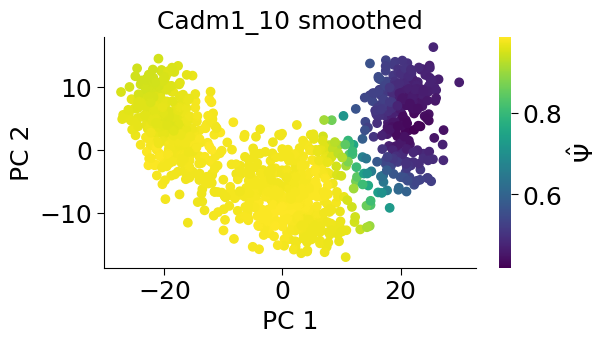

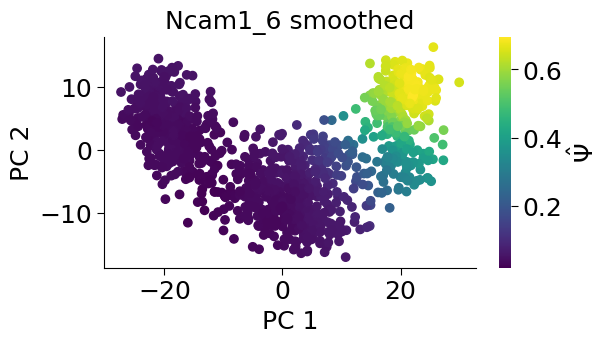

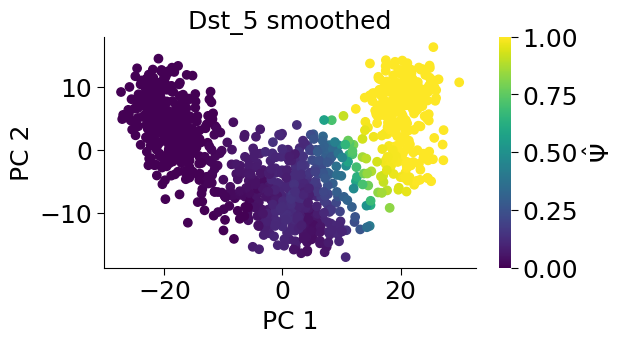

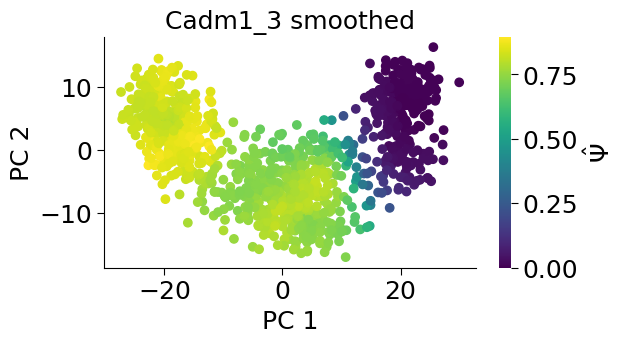

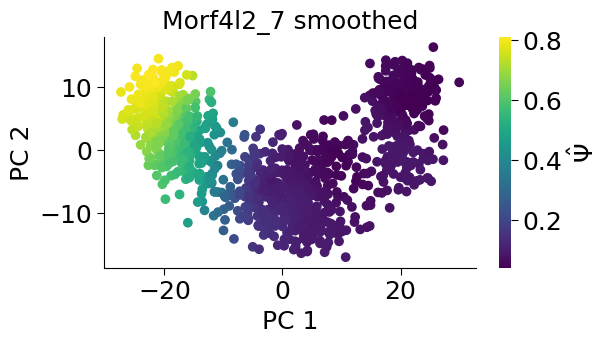

In [82]:
for exon in psix_results[:10].index:
    fig = plt.figure(figsize=(6, 3))
    ax  = plt.subplot(1,1,1)
    sc = ax.scatter(psix_object.adata.uns['latent'].PC_1, psix_object.adata.uns['latent'].PC_2, 
                    c=psix_object.adata.uns['neighbors_psi'][exon])
    # cb = plt.colorbar(sc)
    ax.tick_params(labelsize=18, length=5)
    cb = plt.colorbar(sc, shrink = 1)
    cb.set_label(label='$\hat{\Psi}$',size=18)
    cb.ax.tick_params(labelsize=18, length=5)
    cb.outline.set_visible(False)
    plt.title(exon +' smoothed', fontsize=18)
    plt.xlabel('PC 1', fontsize=18)
    plt.ylabel('PC 2', fontsize=18)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
    
    plt.savefig('plots/' + exon +'.png', bbox_inches='tight', res=100)
    plt.savefig('plots/' + exon +'.svg', bbox_inches='tight')
    plt.savefig('plots/' + exon +'.pdf', bbox_inches='tight')



In [75]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [98]:
norm_expression = pd.read_csv('data/preprocess/tables/scone_norm_tpm_extended.tab.gz', sep='\t', index_col=0)

# norm_expression = np.log1p(pd.read_csv('data/pipeline_output/rsem_gene_tpm.tab.gz', sep='\t', index_col=0))

In [18]:
pseudotime = pd.read_csv('data/preprocess/tables/pseudotime.tab.gz', sep='\t', index_col=0)

(array([929.,  91.,  79.,  95.,  93.,  91.,  53.,  70.,  27.,  12.]),
 array([0.    , 0.4033, 0.8066, 1.2099, 1.6132, 2.0165, 2.4198, 2.8231,
        3.2264, 3.6297, 4.033 ]),
 <a list of 10 Patch objects>)

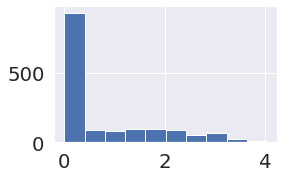

In [29]:
fig = plt.figure(figsize=(4, 2.5))
plt.hist(norm_expression.loc['Nova2'])

In [20]:
pseudotime = pseudotime.sort_values('lineage_1_pseudotime')
order_cells = pseudotime.index

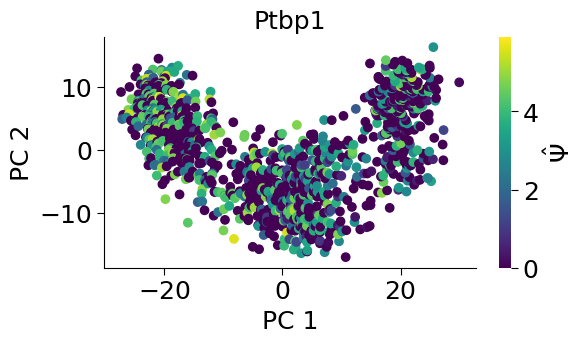

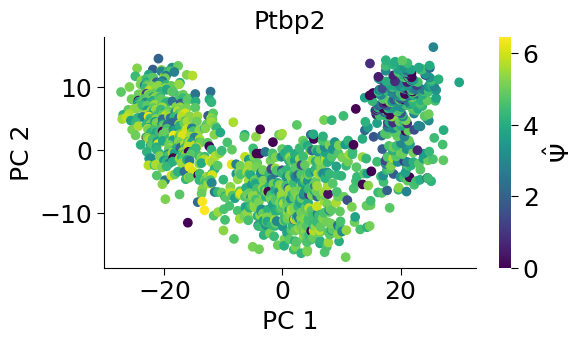

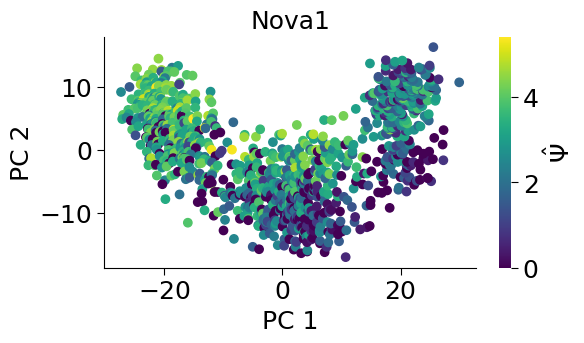

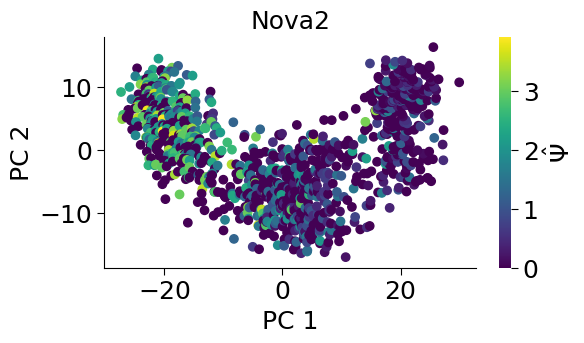

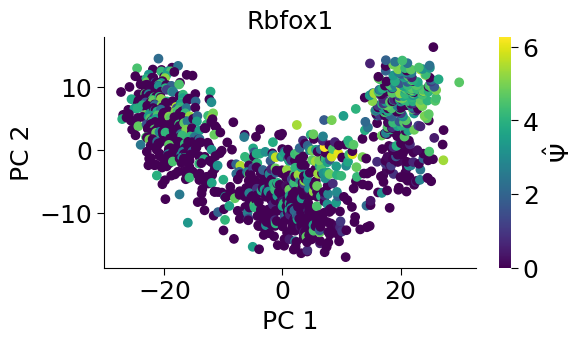

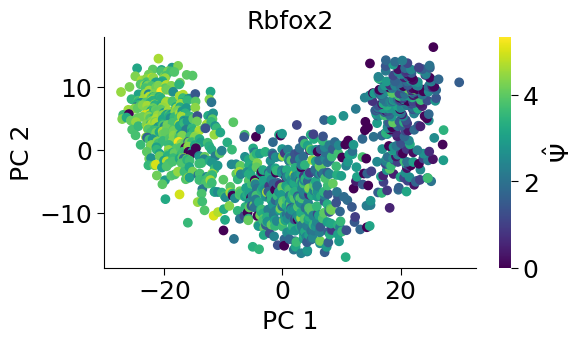

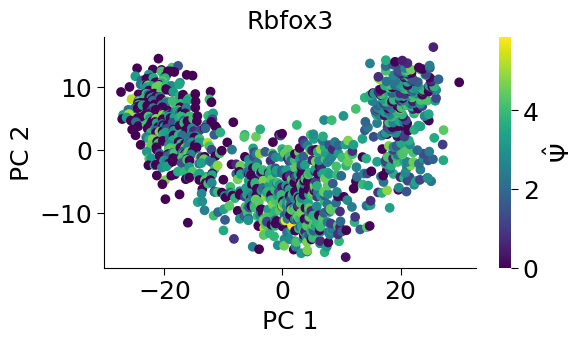

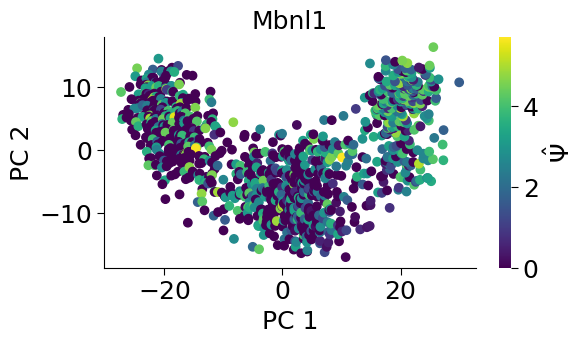

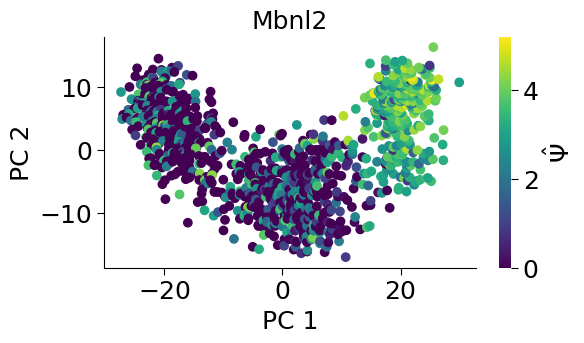

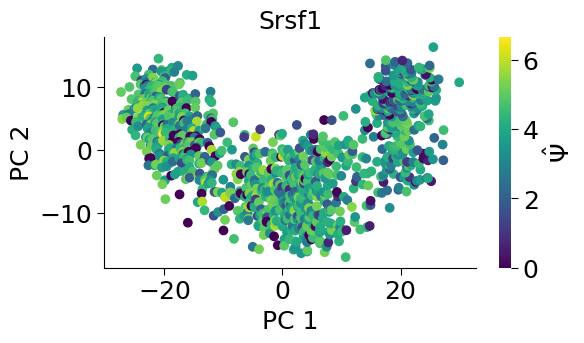

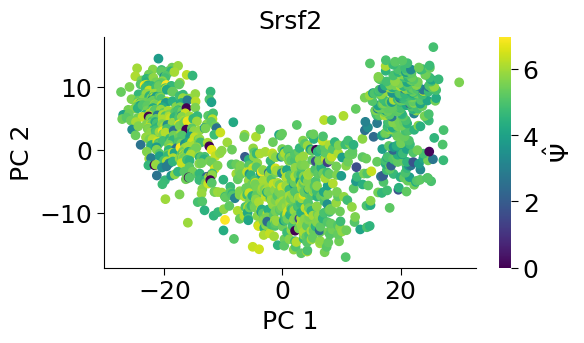

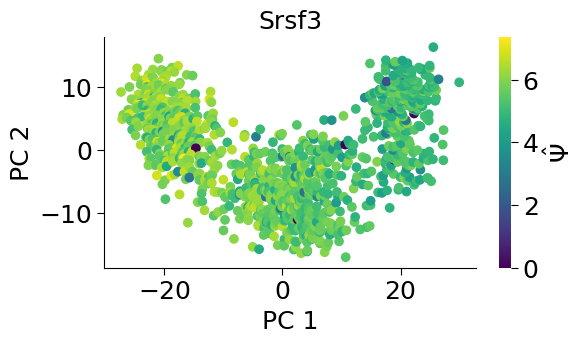

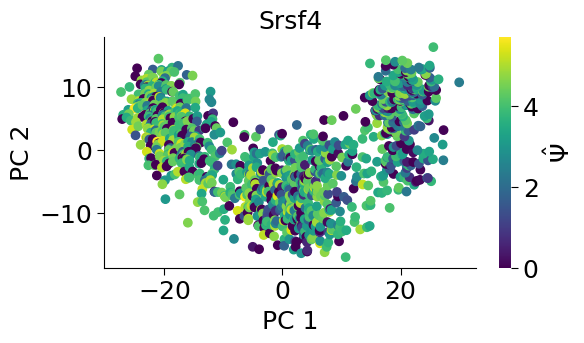

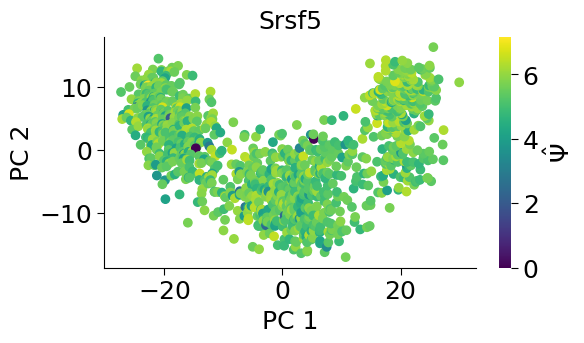

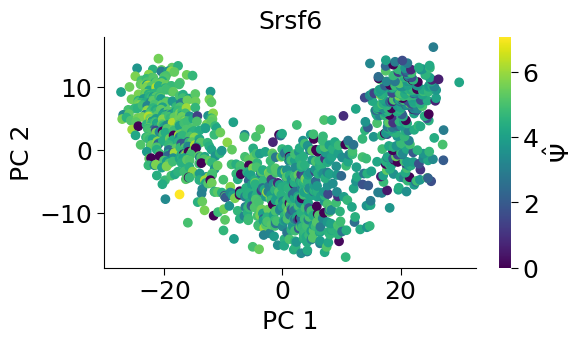

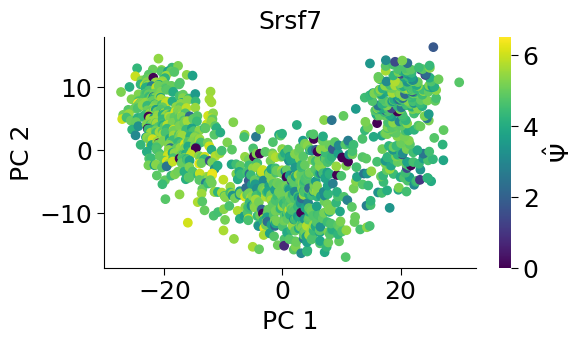

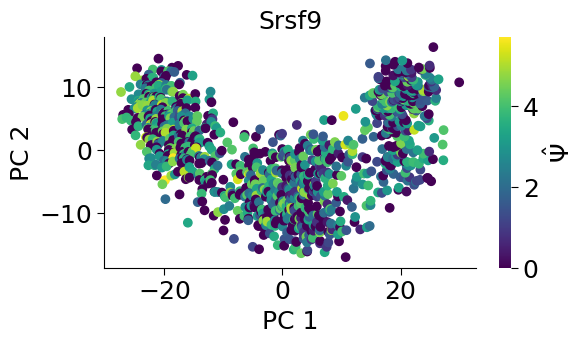

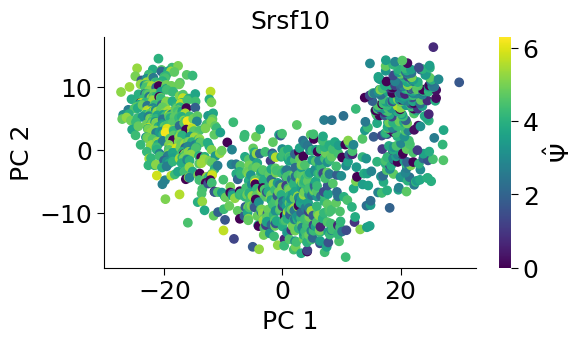

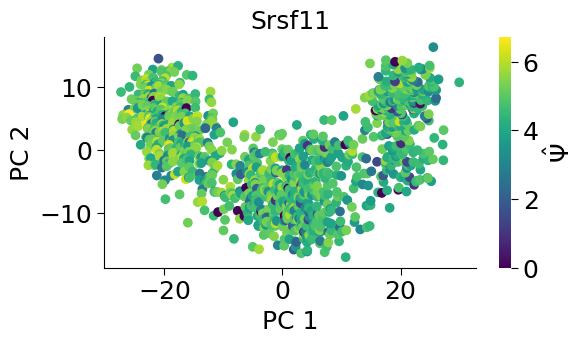

In [79]:

for gene in ['Ptbp1', 'Ptbp2', 'Nova1', 'Nova2', 'Rbfox1', 'Rbfox2', 'Rbfox3', 'Mbnl1', 'Mbnl2',
            'Srsf1', 'Srsf2', 'Srsf3', 'Srsf4', 'Srsf5', 'Srsf6', 'Srsf7', 'Srsf9', 'Srsf10', 'Srsf11']:
    fig = plt.figure(figsize=(6, 3))
    ax  = plt.subplot(1,1,1)
    sc = ax.scatter(psix_object.adata.uns['latent'].loc[order_cells, 'PC_1'], 
                    psix_object.adata.uns['latent'].loc[order_cells, 'PC_2'], 
                    c=norm_expression.loc[gene, order_cells])
    # ax.plot(pseudotime.lineage_1_PC_1, pseudotime.lineage_1_PC_2)
    # cb = plt.colorbar(sc)
    ax.tick_params(labelsize=18, length=5)
    cb = plt.colorbar(sc, shrink = 1)
    cb.set_label(label='$\hat{\Psi}$',size=18)
    cb.ax.tick_params(labelsize=18, length=5)
    cb.outline.set_visible(False)
    plt.title(gene, fontsize=18)
    plt.xlabel('PC 1', fontsize=18)
    plt.ylabel('PC 2', fontsize=18)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
    plt.savefig('plots/' + gene +'.png', bbox_inches='tight', res=100)
    plt.savefig('plots/' + gene +'.svg', bbox_inches='tight')
    plt.savefig('plots/' + gene +'.pdf', bbox_inches='tight')



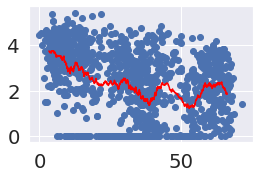

In [39]:
fig = plt.figure(figsize=(4, 2.5))
plt.scatter(pseudotime.lineage_1_pseudotime, norm_expression.loc['Nova1', order_cells])
plt.plot(rolling_average(pseudotime.lineage_1_pseudotime, size=50),
         rolling_average(norm_expression.loc['Nova1', order_cells], size=50), c='red')

In [31]:
def rolling_average(ordered_list, size=10):
    output = [np.mean(ordered_list[i:i+size]) for i in range(len(ordered_list)-size)]
    return output

In [71]:
ptbp_hist = zscore(np.array([rolling_average(norm_expression.loc['Ptbp1', order_cells], 50),
            rolling_average(norm_expression.loc['Ptbp2', order_cells], 50)]), axis=1)

ptbp_hist = pd.DataFrame(ptbp_hist)
ptbp_hist.index = ['Ptbp1', 'Ptbp2']

nova_hist = zscore(np.array([rolling_average(norm_expression.loc['Nova1', order_cells], 50),
            rolling_average(norm_expression.loc['Nova2', order_cells], 50)]), axis=1)

nova_hist = pd.DataFrame(nova_hist)
nova_hist.index = ['Nova1', 'Nova2']

rbfox_hist = zscore(np.array([rolling_average(norm_expression.loc['Rbfox1', order_cells], 50),
            rolling_average(norm_expression.loc['Rbfox2', order_cells], 50),
             rolling_average(norm_expression.loc['Rbfox3', order_cells], 50)]), axis=1)

rbfox_hist = pd.DataFrame(rbfox_hist)
rbfox_hist.index = ['Rova1', 'Rbfox2', 'Rbfox3']


mbnl_hist = zscore(np.array([rolling_average(norm_expression.loc['Mbnl1', order_cells], 50),
            rolling_average(norm_expression.loc['Mbnl2', order_cells], 50)]), axis=1)


mbnl_hist = pd.DataFrame(mbnl_hist)
mbnl_hist.index = ['Mbnl1', 'Mbnl2']

srsf_hist = zscore(np.array([rolling_average(norm_expression.loc['Srsf1', order_cells], 50),
            rolling_average(norm_expression.loc['Srsf2', order_cells], 50),
             rolling_average(norm_expression.loc['Srsf3', order_cells], 50),
                     rolling_average(norm_expression.loc['Srsf4', order_cells], 50),
                     rolling_average(norm_expression.loc['Srsf5', order_cells], 50),
                     rolling_average(norm_expression.loc['Srsf6', order_cells], 50),
                     rolling_average(norm_expression.loc['Srsf7', order_cells], 50),
                     rolling_average(norm_expression.loc['Srsf9', order_cells], 50),
                     rolling_average(norm_expression.loc['Srsf10', order_cells], 50),
                     rolling_average(norm_expression.loc['Srsf11', order_cells], 50)]), axis=1)


srsf_hist = pd.DataFrame(srsf_hist)
srsf_hist.index = ['Srsf1', 'Srsf2', 'Srsf3', 'Srsf4', 'Srsf5', 'Srsf6', 'Srsf7', 'Srsf9', 'Srsf10', 'Srsf11']

[]

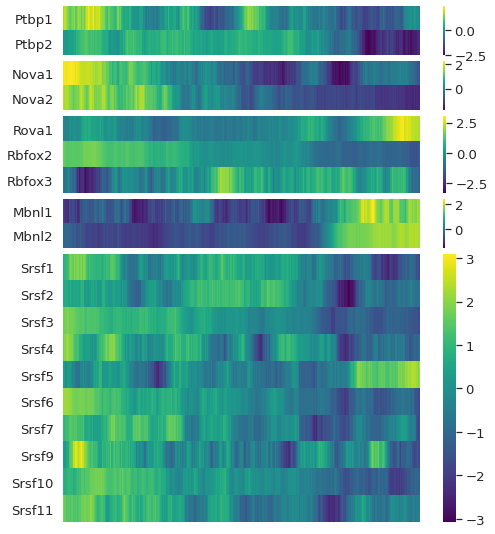

In [73]:
sns.set(font_scale=1.2)

fig = plt.figure(figsize=(8, 10))
gs = GridSpec(20,1)
gs.update(wspace=1, hspace=0.3)

    
ax = fig.add_subplot(gs[0:2, 0])
sns.heatmap(ptbp_hist, cmap='viridis')
plt.yticks(rotation=0) 
ax.set_xticks([])
# ax.tick_params(fontsize=0, length=0)

ax = fig.add_subplot(gs[2:4, 0])
sns.heatmap(nova_hist, cmap='viridis')
plt.yticks(rotation=0) 
ax.set_xticks([])

ax = fig.add_subplot(gs[4:7, 0])
sns.heatmap(rbfox_hist, cmap='viridis')
plt.yticks(rotation=0) 
ax.set_xticks([])

ax = fig.add_subplot(gs[7:9, 0])
sns.heatmap(mbnl_hist, cmap='viridis')
plt.yticks(rotation=0) 
ax.set_xticks([])

ax = fig.add_subplot(gs[9:19, 0])
sns.heatmap(srsf_hist, cmap='viridis')
plt.yticks(rotation=0)
ax.set_xticks([])

#     sc = ax.scatter(psix_object.adata.uns['latent'].PC_1, 
#                     psix_object.adata.uns['latent'].PC_2, 
#                     c=mad_df.mean(axis=1), vmin=-1, vmax=1, cmap='viridis')
    
    
#     plt.title('Module '+str(mod), fontsize=18)
#     if x == 3:
#         plt.xlabel('PC 1', fontsize=18)
#     if y == 0:
#         plt.ylabel('PC 2', fontsize=18)

#     ax.spines["right"].set_visible(False)
#     ax.spines["top"].set_visible(False)
#     ax.tick_params(labelsize=0, length=0)
#     ax.grid(False)
# #     plt.show()

In [54]:
clip_dir = '~/Network/Mouse/SplicingNetwork/L_score_events/tiklova/'

mouse_clip_peaks = (pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0) > 0).astype(int)
se_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_se']
e1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e1']
e2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e2']




mouse_clip_families = pd.DataFrame()
mouse_clip_families['NOVA1_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'NOVA1'])
mouse_clip_families['NOVA1_se'] = np.array(mouse_clip_peaks.loc[se_exons, 'NOVA1'])
mouse_clip_families['NOVA1_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'NOVA1'])

mouse_clip_families['NOVA2_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'NOVA2'])
mouse_clip_families['NOVA2_se'] = np.array(mouse_clip_peaks.loc[se_exons, 'NOVA2'])
mouse_clip_families['NOVA2_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'NOVA2'])

mouse_clip_families['RBFOX1_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'RBFOX1'])
mouse_clip_families['RBFOX1_se'] = np.array(mouse_clip_peaks.loc[se_exons, 'RBFOX1'])
mouse_clip_families['RBFOX1_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'RBFOX1'])

mouse_clip_families['RBFOX2_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'RBFOX2'])
mouse_clip_families['RBFOX2_se'] = np.array(mouse_clip_peaks.loc[se_exons, 'RBFOX2'])
mouse_clip_families['RBFOX2_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'RBFOX2'])

mouse_clip_families['RBFOX3_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'RBFOX3'])
mouse_clip_families['RBFOX3_se'] = np.array(mouse_clip_peaks.loc[se_exons, 'RBFOX3'])
mouse_clip_families['RBFOX3_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'RBFOX3'])

# mouse_clip_families['MBNL_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']])
# mouse_clip_families['MBNL_se'] = np.array(mouse_clip_peaks.loc[se_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']])
# mouse_clip_families['MBNL_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']])

mouse_clip_families['SRSF1_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'SRSF1'])
mouse_clip_families['SRSF1_se'] = np.array(mouse_clip_peaks.loc[se_exons, 'SRSF1'])
mouse_clip_families['SRSF1_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'SRSF1'])

mouse_clip_families['SRSF2_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'SRSF2'])
mouse_clip_families['SRSF2_se'] = np.array(mouse_clip_peaks.loc[se_exons, 'SRSF2'])
mouse_clip_families['SRSF2_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'SRSF2'])

mouse_clip_families['SRSF3_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'SRSF3'])
mouse_clip_families['SRSF3_se'] = np.array(mouse_clip_peaks.loc[se_exons, 'SRSF3'])
mouse_clip_families['SRSF3_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'SRSF3'])

mouse_clip_families['SRSF4_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'SRSF4'])
mouse_clip_families['SRSF4_se'] = np.array(mouse_clip_peaks.loc[se_exons, 'SRSF4'])
mouse_clip_families['SRSF4_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'SRSF4'])

mouse_clip_families['SRSF5_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'SRSF5'])
mouse_clip_families['SRSF5_se'] = np.array(mouse_clip_peaks.loc[se_exons, 'SRSF5'])
mouse_clip_families['SRSF5_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'SRSF5'])

mouse_clip_families['SRSF6_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'SRSF6'])
mouse_clip_families['SRSF6_se'] = np.array(mouse_clip_peaks.loc[se_exons, 'SRSF6'])
mouse_clip_families['SRSF6_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'SRSF6'])

mouse_clip_families['SRSF7_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'SRSF7'])
mouse_clip_families['SRSF7_se'] = np.array(mouse_clip_peaks.loc[se_exons, 'SRSF7'])
mouse_clip_families['SRSF7_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'SRSF7'])
# mouse_clip_families['CELF'] = mouse_clip_peaks['CELF4']#
# mouse_clip_families['TARDBP'] = mouse_clip_peaks['TARDBP']#
# mouse_clip_families['LIN28A'] = mouse_clip_peaks['LIN28A']#
mouse_clip_families.index = [x[:-3] for x in mouse_clip_peaks.index if (x[-3:]=='_se')]

modules = bwow[0]
modules = modules.loc[modules.index & mouse_clip_families.index]
mouse_clip_families = mouse_clip_families.loc[psix_results.index & mouse_clip_families.index]


# mouse_clip_predicted = (mouse_clip_predicted.loc[[x for x in mouse_clip_predicted.index if x[-3:]=='_se']] > 0).astype(int)
# mouse_clip_peaks = (mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:]=='_se']] > 0).astype(int)

# mouse_clip_predicted.index= [x[:-3] for x in mouse_clip_predicted.index if x[-3:]=='_se']
# mouse_clip_peaks.index= [x[:-3] for x in mouse_clip_peaks.index if x[-3:]=='_se']

hyper_enrichment = pd.DataFrame()
hyper_pval_enrich = pd.DataFrame()
hyper_pval_deplete = pd.DataFrame()
for rbp in mouse_clip_families.columns:
    p_enrich = []
    p_deplete = []
    log_enrich = []
    for module in range(1, 8):
        enrichment = test_enrichment(mouse_clip_families[rbp], modules.index[(modules==module)])
        p_enrich.append(enrichment[0])
        p_deplete.append(enrichment[1])
        log_enrich.append(enrichment[2])
        
    hyper_enrichment[rbp] = log_enrich
    hyper_pval_enrich[rbp] = p_enrich
    hyper_pval_deplete[rbp] = p_deplete
    
hyper_enrichment.index = ['M'+ str(x) for x in range(1, 8)]
hyper_pval_enrich.index = ['M'+ str(x) for x in range(1, 8)]
hyper_pval_deplete.index = ['M'+ str(x) for x in range(1, 8)]
    
        
hyper_enrich_significance = pd.DataFrame(multipletests(np.array(hyper_pval_enrich).reshape(1,-1)[0], 
                                                       method='fdr_bh')[1].reshape(7,-7)<=0.1)
hyper_enrich_significance.index = hyper_pval_enrich.index
hyper_enrich_significance.columns = hyper_pval_enrich.columns

labels = hyper_enrich_significance.copy()
for exon in hyper_enrich_significance.index:
    for rbp in hyper_enrich_significance.columns:
        if labels.loc[exon, rbp]:
            labels.loc[exon, rbp] = '*'
        else:
            labels.loc[exon, rbp] = ''
# from statsmodels.stats.multitest import multipletests

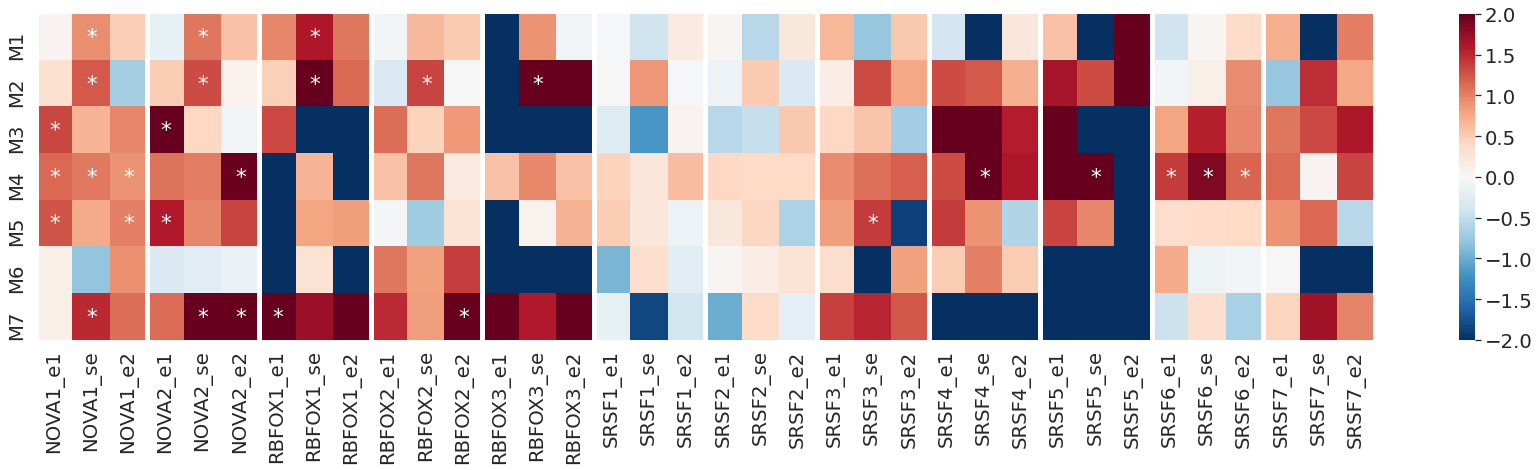

In [56]:
sns.set(font_scale=1.8)

fig = plt.figure(figsize=(30, 6))
ax = sns.heatmap(hyper_enrichment, cmap='RdBu_r', vmin=-2, vmax=2, annot=labels, fmt='')
for i in range(0, hyper_enrichment.shape[1] + 1, 3):
    ax.axvline(i, color='white', lw=5)
# for i in range(data.shape[1] + 1):
#     ax.axvline(i, color='white', lw=60)
plt.show()

Aamdc_10   Aamdc_9  Aasdhppt_2    Abat_3   Abca3_4  Abhd10_1  \
SRR7408400  0.890528  0.881441    0.837492  0.654847  0.707010  0.090529   
SRR7408401  0.815149  0.855939    0.856691  0.852417  0.806091  0.068425   
SRR7408404  0.868235  0.884410    0.846578  0.952363  0.809490  0.053640   
SRR7408413  0.909925  0.911149    0.856244  0.965393  0.798121  0.058788   
SRR7408414  1.000000  0.857610    0.804791  0.824243  0.769893  0.020250   
...              ...       ...         ...       ...       ...       ...   
SRR7410092  0.940126  0.869562    0.981647  0.982967  0.719575  0.159813   
SRR7410093  0.940887  0.780034    0.983830  0.958131  0.864132  0.165852   
SRR7410094  0.939535  0.853680    0.966350  0.975532  0.625715  0.143625   
SRR7410096  0.918581  0.830691    0.979246  0.964183  0.800496  0.178325   
SRR7410097  0.910070  0.848117    0.941081  0.979605  0.648525  0.107129   

            Abhd10_2  Abhd14a_1  Abhd14a_3    Abi1_8  ...   Zmym3_7  \
SRR7408400  0.890356   0.377322   0.352761  0.492005  ...  0.926147   
SRR7408401  0.894091   0.275333   0.220361  0.533256  ...  0.949115   
SRR7408404  0.916427   0.271018   0.219291  0.520001  ...  0.937012   
SRR7408413  0.924201   0.253957   0.211478  0.484949  ...  0.921839   
SRR7408414  0.879144   0.369119   0.345410  0.451855  ...  0.950293   
...              ...        ...        ...       ...  ...       ...   
SRR7410092  0.936753   0.362303   0.326897  0.284127  ...  0.976264   
SRR7410093  0.879501   0.498720   0.472374  0.422143  ...  0.971398   
SRR7410094  0.944189   0.365961   0.324178  0.315866  ...  0.970274   
SRR7410096  0.841568   0.397959   0.392232  0.404131  ...  0.974155   
SRR7410097  0.846965   0.332211   0.320421  0.382527  ...  0.959313   

            Zmynd11_7  Zmynd8_6  Zmynd8_8  Znhit1_1  Zscan18_1     Zyx_1  \
SRR7408400   0.794880  0.920628  0.529841  0.049728   0.817872  0.656596   
SRR7408401   0.698370  0.920897  0.553690  0.137205   1.000000  0.764913   
SRR7408404   0.638555  0.939579  0.562549  0.135271   1.000000  0.712975   
SRR7408413   0.627064  0.961022  0.586026  0.117739   0.977523  0.687229   
SRR7408414   0.615415  0.971463  0.509638  0.120240   0.909824  0.683343   
...               ...       ...       ...       ...        ...       ...   
SRR7410092   0.720524  0.650909  0.520312  0.108081   0.983558  0.643402   
SRR7410093   0.703109  0.630674  0.591007  0.089103   0.906900  0.660221   
SRR7410094   0.760185  0.609890  0.514324  0.104591   0.966448  0.626797   
SRR7410096   0.700750  0.487957  0.565123  0.069023   0.906394  0.668719   
SRR7410097   0.731417  0.560357  0.467929  0.100376   0.892637  0.668034   

             l7Rn6_1   l7Rn6_3  l7Rn6_nmdSE_1  
SRR7408400  0.810534  0.028833       0.070553  
SRR7408401  0.765286  0.029742       0.022497  
SRR7408404  0.790725  0.013075       0.000000  
SRR7408413  0.786436  0.017126       0.000000  
SRR7408414  0.719657  0.012082       0.000000  
...              ...       ...            ...  
SRR7410092  0.898073  0.072465       0.065063  
SRR7410093  0.932777  0.113521       0.099716  
SRR7410094  0.876469  0.063486       0.046157  
SRR7410096  0.937405  0.104000       0.096868  
SRR7410097  0.934322  0.053432       0.058457  

[1067 rows x 2087 columns]

In [89]:
psix_object = psix.Psix()
psix_object.process_rnaseq(
        'data/preprocess/tables/p90_SE_counts_filtered.tab.gz',
        'data/preprocess/tables/p90_constitutive_introns_filtered.tab.gz',
        'data/preprocess/tables/p90_rsem_gene_tpm_filtered.tab.gz',
        minJR = 1,
        minCell=1,
        min_observed = 0.25)

Obtaining psi tables...
Reading TPM and transforming to mRNA counts...


100%|██████████| 290/290 [00:12<00:00, 23.13it/s]


Successfully processed RNA-seq data


In [90]:
psix_object.compute_psix_scores(latent='data/preprocess/tables/p90_pc2_rd.tab.gz', n_jobs=25, 
                                n_random_exons=2000, n_neighbors=30)

100%|██████████| 290/290 [00:00<00:00, 16457.38it/s]

cell-cell metric not found. Computing metric...
Successfully computed cell-cell metric
Computing Psix score in 2115 exons



100%|██████████| 2115/2115 [00:07<00:00, 282.55it/s]


Successfully computed Psix score of exons.
...

Estimating p-values. This might take a while...


100%|██████████| 25/25 [02:24<00:00,  5.77s/it]


Successfully estimated p-values


In [92]:
psix_object.compute_neighbors_psi()

Successfully computed neighbors


In [93]:
psix_object.adata.uns['neighbors_psi'].T.to_csv('data/preprocess/tables/neighbors_psi_p90.tab.gz', sep='\t', 
                                                index=True, header=True)

psix_object.adata.uns['psi'].T.to_csv('data/preprocess/tables/psi_p90.tab.gz', sep='\t', 
                                                index=True, header=True)

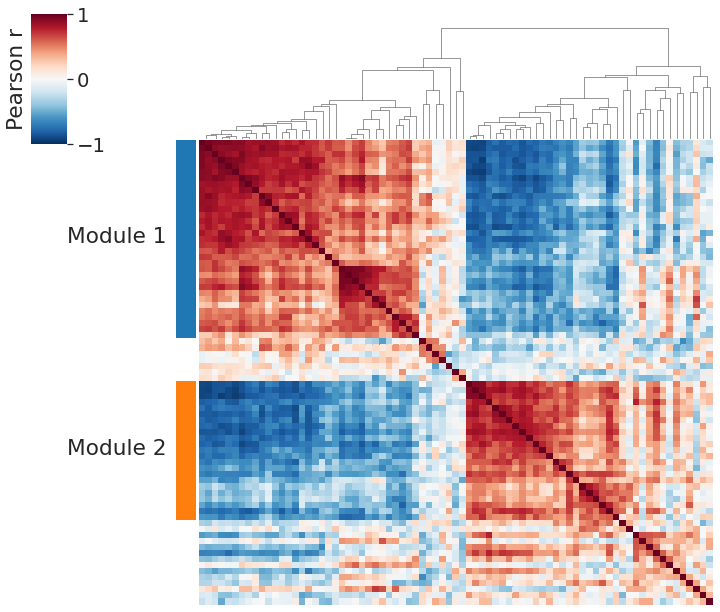

In [114]:
import sys
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/psix_project/analysis_psix/utils/')
from misc_utils import *

psix_results = psix_object.psix_results

background_psi = psix_object.adata.uns['neighbors_psi'].mask(psix_object.adata.uns['psi'].isna()).T
exon_list = psix_results.loc[(psix_results.psix_score > 0) & (psix_results.qvals <= 0.05)].index

bwow = compute_modules(background_psi.loc[exon_list].T.corr().fillna(0), 
                min_gene_threshold=20, fdr_threshold=None, z_threshold=0.3, core_only=False)

aver = local_correlation_plot(
            background_psi.loc[exon_list].T.corr().fillna(0), bwow[0], bwow[1],
            mod_cmap='tab10', vmin=-1, vmax=1,
            z_cmap='RdBu_r', yticklabels=False
)

In [116]:
psix_object.save_psix_object('psix_object_p90/', overwrite=True)
pd.DataFrame(bwow[0]).to_csv('psix_object_p90/modules_p90.tab.gz', sep='\t', index=True, header=True)

In [39]:
psix_object.psix_results

psix_score     pvals     qvals
Nrxn1_4           0.534807  0.000500  0.019574
Aplp2_3           0.510770  0.000500  0.019574
Stxbp1_2          0.488766  0.000500  0.019574
Cadps_7           0.463514  0.000500  0.019574
Bnip2_nmdSE_1     0.428936  0.000500  0.019574
...                    ...       ...       ...
Zfp688_nmdSE_1   -0.265449  0.992504  0.999227
Nasp_5           -0.269500  0.994503  0.999227
Brsk2_10         -0.278889  0.997501  1.000000
Srsf11_nmdSE_4   -0.291752  0.997501  1.000000
Alkbh3_3         -0.302672  0.997501  1.000000

[2115 rows x 3 columns]

# Gene expression autocorrelation

In [25]:
import hotspot
from sklearn.preprocessing import StandardScaler

psix_results = pd.read_csv('psix_object/psix_results.tab.gz', sep='\t', index_col=0)
modules = pd.read_csv('psix_object/modules.tab.gz', sep='\t', index_col=0)
norm_expression = pd.read_csv('data/preprocess/tables/scone_norm_tpm_extended.tab.gz', sep='\t', index_col=0)
psi =  pd.read_csv('data/preprocess/tables/psi.tab.gz', sep='\t', index_col=0)
neighbors_psi = pd.read_csv('data/preprocess/tables/neighbors_psi.tab.gz', sep='\t', index_col=0)
latent = pd.read_csv('data/preprocess/tables/pc2_rd.tab.gz', sep='\t', index_col=0)

scaled_counts = pd.DataFrame(StandardScaler().fit_transform(norm_expression[latent.index].T).T)
scaled_counts.index = norm_expression.index
scaled_counts.columns = latent.index

hs = hotspot.Hotspot(norm_expression[latent.index], model='danb', latent=latent, 
                     umi_counts=np.ones(len(latent.index)))
hs.create_knn_graph(weighted_graph=False, n_neighbors=10)
hs_results = hs.compute_autocorrelations()

hs_genes = hs_results.loc[(hs_results.FDR < 0.01)].index # Select genes
local_correlations = hs.compute_local_correlations(hs_genes, jobs=4) # jobs for parallelization

  8%|▊         | 491/6345 [00:00<00:01, 4902.36it/s]

Computing pair-wise local correlation on 6345 features...


100%|██████████| 20126340/20126340 [27:54<00:00, 12019.04it/s] 


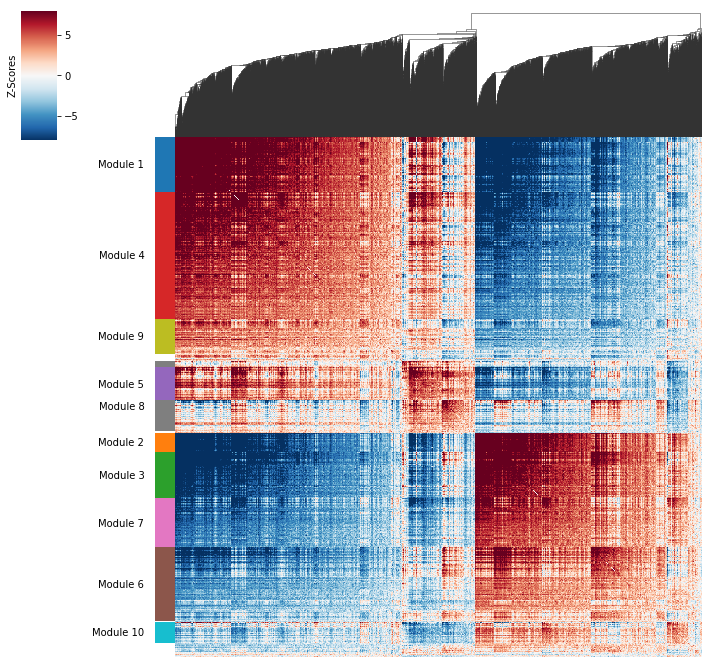

In [26]:
modules = hs.create_modules(
    min_gene_threshold=100, core_only=False, fdr_threshold=0.05
)

hs.plot_local_correlations()

In [27]:
pd.DataFrame(modules).to_csv('psix_object/modules_genes.tab.gz', sep='\t', index=True, header=True)

In [46]:
hs.results.to_csv('psix_object/hotspot.tab.gz', sep='\t', index=True, header=True)

In [2]:
import hotspot
from sklearn.preprocessing import StandardScaler

psix_results = pd.read_csv('psix_object/psix_results.tab.gz', sep='\t', index_col=0)
modules = pd.read_csv('psix_object/modules.tab.gz', sep='\t', index_col=0)
norm_expression = pd.read_csv('data/preprocess/tables/scone_norm_tpm_extended.tab.gz', sep='\t', index_col=0)
psi =  pd.read_csv('data/preprocess/tables/psi.tab.gz', sep='\t', index_col=0)
neighbors_psi = pd.read_csv('data/preprocess/tables/neighbors_psi.tab.gz', sep='\t', index_col=0)
latent = pd.read_csv('data/preprocess/tables/pc2_rd.tab.gz', sep='\t', index_col=0)

splicing_factors = pd.read_csv('~/Network/Metadata/mouse_splicing_factors.txt', sep='\t', index_col=0).index

In [4]:
norm_expression.index & splicing_factors

Index(['Hnrnpd', 'Ddx3x', 'Fmr1', 'Top1mt', 'Ilf2', 'Pcbp3', 'Snrnp27',
       'Crnkl1', 'Celf2', 'Sf3a1',
       ...
       'Srsf3', 'Tia1', 'Snrnp40', 'Snrnp40', 'Eif2s2', 'U2af1l4', 'U2af1l4',
       'Lsm5', 'Hspa1a', 'Snrpn'],
      dtype='object', length=221)

100%|██████████| 114/114 [00:00<00:00, 5031.47it/s]

Computing pair-wise local correlation on 108 features...



100%|██████████| 6441/6441 [00:01<00:00, 5520.92it/s]


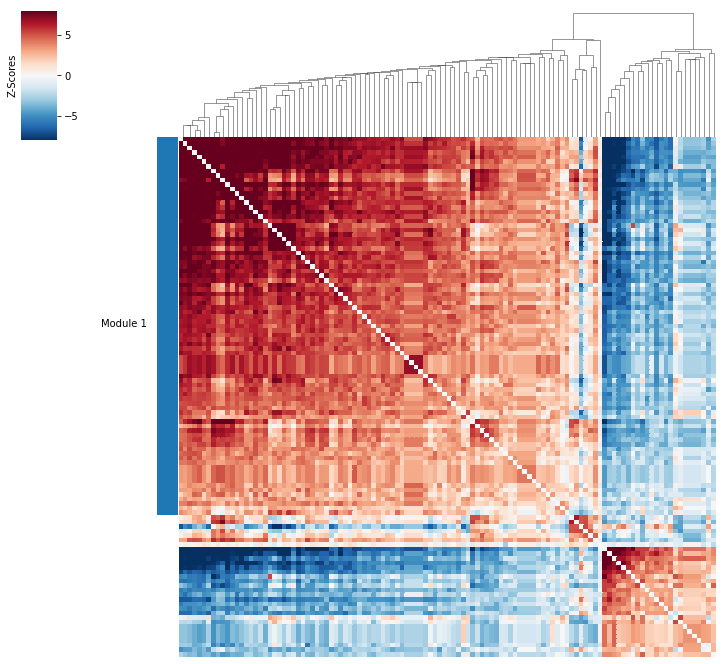

In [6]:
hs = hotspot.Hotspot(norm_expression.loc[norm_expression.index & splicing_factors, latent.index], model='danb', 
                     latent=latent, 
                     umi_counts=np.ones(len(latent.index)))
hs.create_knn_graph(weighted_graph=False, n_neighbors=10)
hs_results = hs.compute_autocorrelations()

hs_genes = hs_results.loc[(hs_results.FDR < 0.01)].index # Select genes
local_correlations = hs.compute_local_correlations(hs_genes, jobs=4) # jobs for parallelization

modules = hs.create_modules(
    min_gene_threshold=30, core_only=False, fdr_threshold=0.05
)

hs.plot_local_correlations()

In [99]:
import hotspot
from sklearn.preprocessing import StandardScaler

latent_p90 = pd.read_csv('data/preprocess/tables/p90_pc2_rd.tab.gz', sep='\t', index_col=0)

from sklearn.preprocessing import StandardScaler
scaled_counts_p90 = pd.DataFrame(StandardScaler().fit_transform(norm_expression[latent_p90.index].T).T)
scaled_counts_p90.index = norm_expression.index
scaled_counts_p90.columns = latent_p90.index

hs_p90 = hotspot.Hotspot(norm_expression[latent_p90.index], model='danb', latent=latent_p90, 
                     umi_counts=np.ones(len(latent_p90.index)))
hs_p90.create_knn_graph(weighted_graph=False, n_neighbors=10)
hs_results_p90 = hs_p90.compute_autocorrelations()

hs_genes_p90 = hs_results_p90.loc[(hs_results_p90.FDR < 0.01)].index # Select genes
local_correlations_p90 = hs_p90.compute_local_correlations(hs_genes_p90, jobs=4) # jobs for parallelization


Removing 7 undetected/non-varying genes


100%|██████████| 885/885 [00:00<00:00, 8142.30it/s]


Computing pair-wise local correlation on 885 features...


100%|██████████| 391170/391170 [00:20<00:00, 18885.23it/s]


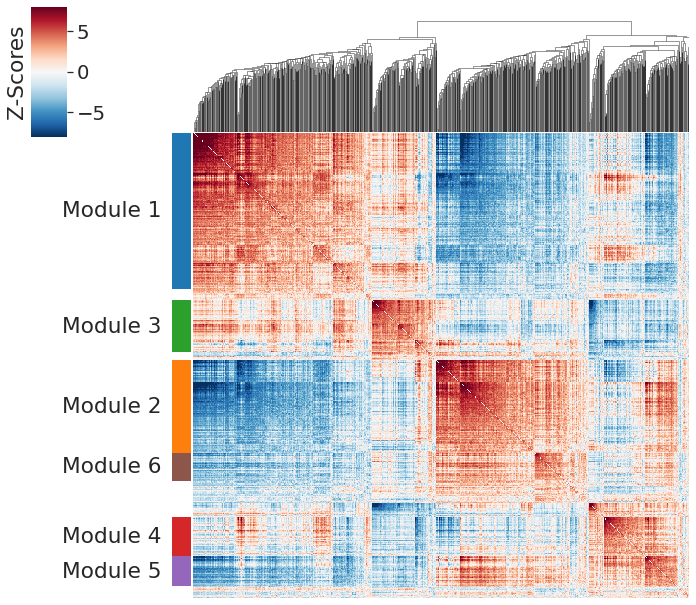

In [100]:
modules_p90 = hs_p90.create_modules(
    min_gene_threshold=50, core_only=False, fdr_threshold=0.05
)

hs_p90.plot_local_correlations()

In [101]:
pd.DataFrame(modules_p90).to_csv('psix_object_p90/modules_genes_p90.tab.gz', sep='\t', index=True, header=True)

In [102]:
hs_p90.results.to_csv('psix_object_p90/hotspot_p90.tab.gz', sep='\t', index=True, header=True)

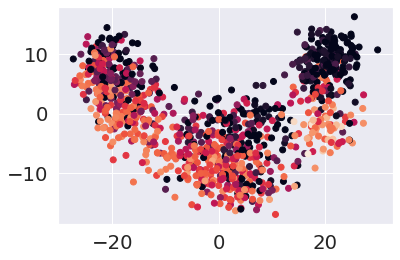

In [120]:
psix_results = pd.read_csv('psix_object/psix_results.tab.gz', sep='\t', index_col=0)
modules = pd.read_csv('psix_object/modules.tab.gz', sep='\t', index_col=0)
norm_expression = pd.read_csv('data/preprocess/tables/scone_norm_tpm_extended.tab.gz', sep='\t', index_col=0)
psi =  pd.read_csv('data/preprocess/tables/psi.tab.gz', sep='\t', index_col=0)
neighbors_psi = pd.read_csv('data/preprocess/tables/neighbors_psi.tab.gz', sep='\t', index_col=0)
latent = pd.read_csv('data/preprocess/tables/pc2_rd.tab.gz', sep='\t', index_col=0)


plt.scatter(latent.PC_1, latent.PC_2, c=norm_expression.loc['Cck', latent.index])